In [1]:
import pydicom
import os,re
import numpy as np
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from pydicom.dataset import Dataset, FileDataset
import tempfile
import SimpleITK as sitk
import math
from ipywidgets import interact, fixed
from skimage.transform import resize
from IPython.display import clear_output
from scipy.ndimage import zoom
import scipy.misc

from sys import platform
import shutil
platform

'win32'

In [16]:
p=512
ESP=0.1

def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    plt.figure()
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    #clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))


def save_transform_and_image(transform, fixed_image, moving_image, fixed_ori,moving_ori, dicompath, outputfile_prefix,multi_tp):
                           
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)
    # SimpleITK supports several interpolation options, we go with the simplest that gives reasonable results.     
    resample.SetInterpolator(sitk.sitkLinear)  
    resample.SetTransform(transform)
    #sitk.WriteImage(resample.Execute(moving_image), outputfile_prefix+'.mha')
    #sitk.WriteTransform(transform, outputfile_prefix+'.tfm')
    max_moving = 0
    exqimg = sitk.GetArrayFromImage(resample.Execute(moving_image))
    for i in range(0,exqimg.shape[2]):
        max_moving = max(max_moving,np.amax(exqimg[:,:,i]))
    
    
    if multi_tp == False:

        ds_ori = pydicom.dcmread(fixed_ori[0])
        ds_ori_end = pydicom.dcmread(fixed_ori[-1])
        sp_x = (ds_ori_end[0x20,0x32].value[0]-ds_ori[0x20,0x32].value[0])/len(fixed_ori)
        sp_y = (ds_ori_end[0x20,0x32].value[1]-ds_ori[0x20,0x32].value[1])/len(fixed_ori)
        sp_z = (ds_ori_end[0x20,0x32].value[2]-ds_ori[0x20,0x32].value[2])/len(fixed_ori)
        a =  abs(float(ds_ori[0x20,0x32].value[0])-float(ds_ori_end[0x20,0x32].value[0]))
        b =  abs(float(ds_ori[0x20,0x32].value[1])-float(ds_ori_end[0x20,0x32].value[1]))
        c =  abs(float(ds_ori[0x20,0x32].value[2])-float(ds_ori_end[0x20,0x32].value[2]))
        spori = -math.sqrt(sp_x*sp_x+sp_y*sp_y+sp_z*sp_z)
        slicelocation_axis = 'x'
        if min(a,b,c)==b:
            slicelocation_axis = 'y'
        elif min(a,b,c)==c:
            slicelocation_axis = 'z'


        if len(moving_ori)<len(fixed_ori):
            reg_img = resample.Execute(moving_image)
            #reg_img_resample = zoom(reg_img, (1, 1, len(moving_ori)/len(fixed_ori)))

            new_x_size = (reg_img.GetSize())[0] 
            new_y_size = (reg_img.GetSize())[1]
            new_z_size = len(moving_ori) #downsample
            new_size = [new_x_size, new_y_size, new_z_size]
            new_spacing = [old_sz*old_spc/new_sz  for old_sz, old_spc, new_sz in zip(reg_img.GetSize(), reg_img.GetSpacing(), new_size)]
            interpolator_type = sitk.sitkLinear

            reg_img_resample = sitk.Resample(reg_img, new_size, sitk.Transform(),\
                                             interpolator_type, reg_img.GetOrigin(),\
                                             new_spacing, reg_img.GetDirection(), 0.0, reg_img.GetPixelIDValue())
            
            #new_reg_img_resample = (reg_img_resample-0)/(max_moving-0)*p
            new_reg_img_resample = reg_img_resample
            for i in range(0,len(moving_ori)): 
                path = moving_ori[i]
                ds = pydicom.dcmread(path)
                head,tail = os.path.split(path) 
                #new_data = ds.pixel_array
                new_data = sitk.GetArrayFromImage(new_reg_img_resample[:,:,i])
                #new_data = (new_data-np.amin(new_data))/(np.amax(new_data)-np.amin(new_data)+ESP)*p
                #new_data[new_data<0]=0
                #new_data[new_data>p]=p
                new_data = (new_data).astype('uint16')
                sp = -(spori)*(len(fixed_ori)/len(moving_ori))
                xsp = (sp_x)*(len(fixed_ori)/len(moving_ori))
                ysp = (sp_y)*(len(fixed_ori)/len(moving_ori))
                zsp = (sp_z)*(len(fixed_ori)/len(moving_ori))
                #print((float(ds_ori[0x18,0x88].value)),len(fixed_ori),len(moving_ori),sp)
                ds[0x18,0x88].value = sp

                ds[0x20,0x37].value = ds_ori[0x20,0x37].value
                '''
                if slicelocation_axis == 'x':
                    ds.SliceLocation = ds_ori.SliceLocation+xsp*i
                elif slicelocation_axis == 'y':
                    ds.SliceLocation = ds_ori.SliceLocation+ysp*i
                elif slicelocation_axis == 'z':
                    ds.SliceLocation = ds_ori.SliceLocation+zsp*i
                '''
                orientation = [ds_ori[0x20,0x32].value[0]+xsp*i,\
                                ds_ori[0x20,0x32].value[1]+ysp*i,ds_ori[0x20,0x32].value[2]+zsp*i]
                ds[0x20,0x32].value =  orientation
                ds[0x28,0x10].value = ds_ori[0x28,0x10].value
                ds[0x28,0x11].value = ds_ori[0x28,0x11].value
                ds[0x28,0x30].value = ds_ori[0x28,0x30].value
                ds.PixelData = new_data.tostring()
                newpath = dicompath+ tail
                ds.save_as(newpath)
                print(newpath)

        elif len(moving_ori)>=len(fixed_ori):    
            for i in range(0,len(moving_ori)): 
                path = moving_ori[i]
                ds = pydicom.dcmread(path)
                head,tail = os.path.split(path)
                reg_img = resample.Execute(moving_image)
                
                #new_reg_img = (reg_img-0)/(max_moving-0)*p
                new_reg_img = reg_img
                if i < len(fixed_ori):
                    ds_ori = pydicom.dcmread(fixed_ori[i])
                    #new_data = ds.pixel_array
                    new_data = sitk.GetArrayFromImage(new_reg_img[:,:,i])
                    #new_data = (new_data-np.amin(new_data))/(np.amax(new_data)-np.amin(new_data)+ESP)*p
                    #new_data[new_data<0]=0
                    #new_data[new_data>p]=p
                    new_data = (new_data).astype('uint16')
                    ds[0x20,0x32].value = ds_ori[0x20,0x32].value
                    ds[0x20,0x37].value = ds_ori[0x20,0x37].value
                    #ds.SliceLocation = ds_ori.SliceLocation
                    ds[0x28,0x10].value = ds_ori[0x28,0x10].value
                    ds[0x28,0x11].value = ds_ori[0x28,0x11].value
                    ds[0x28,0x30].value = ds_ori[0x28,0x30].value
                    ds.PixelData = new_data.tostring()
                    newpath = dicompath+ tail
                    ds.save_as(newpath)
                    print(newpath)
                else:
                    ds_ori = pydicom.dcmread(fixed_ori[-1])
                    new_data = np.zeros((ds_ori.Rows,ds_ori.Columns))            
                    new_data = (new_data).astype('uint16')
                   # sp = -(float(ds_ori[0x18,0x88].value))
                    xsp = (sp_x)*(len(fixed_ori)/len(moving_ori))
                    ysp = (sp_y)*(len(fixed_ori)/len(moving_ori))
                    zsp = (sp_z)*(len(fixed_ori)/len(moving_ori))
                    orientation = [ds_ori[0x20,0x32].value[0]+xsp*(i-len(fixed_ori)),\
                                   ds_ori[0x20,0x32].value[1]+ysp*(i-len(fixed_ori))\
                                   ,ds_ori[0x20,0x32].value[2]+zsp*(i-len(fixed_ori))]
                    ds[0x20,0x32].value =  orientation


                    ds[0x20,0x37].value = ds_ori[0x20,0x37].value
                    '''
                    if slicelocation_axis == 'x':
                        ds.SliceLocation = ds_ori.SliceLocation+xsp*(i-len(fixed_ori))
                    elif slicelocation_axis == 'y':
                        ds.SliceLocation = ds_ori.SliceLocation+ysp*(i-len(fixed_ori))
                    elif slicelocation_axis == 'z':
                        ds.SliceLocation = ds_ori.SliceLocation+zsp*(i-len(fixed_ori))
                    '''
                    #ds.SliceLocation = ds_ori.SliceLocation+sp*(i-len(fixed_ori))
                    ds[0x28,0x30].value = ds_ori[0x28,0x30].value
                    ds.Rows = ds_ori.Rows
                    ds.Columns = ds_ori.Columns
                    ds.PixelData = new_data.tostring()
                    newpath = dicompath+ tail
                    ds.save_as(newpath)
                    print(newpath)


           # ds = pydicom.dcmread(newpath)
           # img = ds.pixel_array
           # plt.figure()
           # plt.imshow(img)
           # plt.show()
           # plt.close()
    else:
        reg_img = resample.Execute(moving_image)
        new_reg_img = reg_img
        #new_reg_img = (reg_img-0)/(max_moving-0)*p
        for i in range(0,len(moving_ori)): 
            path = moving_ori[i]
            ds = pydicom.dcmread(path)
            head,tail = os.path.split(path)
            ds_ori = pydicom.dcmread(fixed_ori[i])
            #new_data = ds.pixel_array
            new_data = sitk.GetArrayFromImage((new_reg_img)[:,:,i])
            #new_data = (new_data-np.amin(new_data))/(np.amax(new_data)-np.amin(new_data)+ESP)*p
            #new_data[new_data<0]=0
            #new_data[new_data>p]=p
            new_data = (new_data).astype('uint16')
            ds[0x20,0x32].value = ds_ori[0x20,0x32].value
            ds[0x20,0x37].value = ds_ori[0x20,0x37].value
            #ds.SliceLocation = ds_ori.SliceLocation
            ds[0x28,0x10].value = ds_ori[0x28,0x10].value
            ds[0x28,0x11].value = ds_ori[0x28,0x11].value
            ds[0x28,0x30].value = ds_ori[0x28,0x30].value
            ds.PixelData = new_data.tostring()
            newpath = dicompath+ tail
            ds.save_as(newpath)
            print(newpath)
        
def DICOM_series_dropdown_callback(fixed_image, moving_image, series_dictionary):
    """
    Callback from dropbox which selects the two series which will be used for registration.
    The callback prints out some information about each of the series from the meta-data dictionary.
    For a list of all meta-dictionary tags and their human readable names see DICOM standard part 6, 
    Data Dictionary (http://medical.nema.org/medical/dicom/current/output/pdf/part06.pdf)
    """
    # The callback will update these global variables with the user selection.
    global selected_series_fixed
    global selected_series_moving
    
    img_fixed = sitk.ReadImage(series_dictionary[fixed_image][0])
    img_moving = sitk.ReadImage(series_dictionary[moving_image][0])
    
    # There are many interesting tags in the DICOM data dictionary, display a selected few.
    tags_to_print = {'0010|0010': 'Patient name: ', 
                     '0008|0060' : 'Modality: ',
                     '0008|0021' : 'Series date: ',
                     '0008|0031' : 'Series time:',
                     '0008|0070' : 'Manufacturer: '}
    html_table = []
    html_table.append('<table><tr><td><b>Tag</b></td><td><b>Fixed Image</b></td><td><b>Moving Image</b></td></tr>')
    for tag in tags_to_print:
        fixed_tag = ''
        moving_tag = ''
        try:            
            fixed_tag = img_fixed.GetMetaData(tag)
        except: # ignore if the tag isn't in the dictionary
            pass
        try:            
            moving_tag = img_moving.GetMetaData(tag)
        except: # ignore if the tag isn't in the dictionary
            pass           
        html_table.append('<tr><td>' + tags_to_print[tag] + 
                          '</td><td>' + fixed_tag + 
                          '</td><td>' + moving_tag + '</td></tr>')
    html_table.append('</table>')
    display(HTML(''.join(html_table)))
    selected_series_fixed = fixed_image
    selected_series_moving = moving_image    
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

from IPython.display import clear_output
from scipy import linalg 
from registration_utilities import registration_errors


# Callback we associate with the StartEvent, sets up our new data.
def metric_start_plot():
    global metric_values, multires_iterations
    global current_iteration_number
    
    metric_values = []
    multires_iterations = []
    current_iteration_number = -1

# Callback we associate with the EndEvent, do cleanup of data and figure.
def metric_end_plot():
    global metric_values, multires_iterations
    global current_iteration_number

    del metric_values
    del multires_iterations
    del current_iteration_number
    # Close figure, we don't want to get a duplicate of the plot latter on
    plt.close()

# Callback we associate with the IterationEvent, update our data and display 
# new figure.    
def metric_plot_values(registration_method):
    global metric_values, multires_iterations
    global current_iteration_number
    
    # Some optimizers report an iteration event for function evaluations and not
    # a complete iteration, we only want to update every iteration.
    if registration_method.GetOptimizerIteration() == current_iteration_number:
        return

    current_iteration_number =  registration_method.GetOptimizerIteration()
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot 
    # current data.
    #clear_output(wait=True)
    # Plot the similarity metric values.
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback we associate with the MultiResolutionIterationEvent, update the 
# index into the metric_values list. 
def metric_update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))        

# Callback we associate with the StartEvent, sets up our new data.
def metric_and_reference_start_plot():
    global metric_values, multires_iterations, reference_mean_values
    global reference_min_values, reference_max_values
    global current_iteration_number

    metric_values = []
    multires_iterations = []
    reference_mean_values = []
    reference_min_values = []
    reference_max_values = []
    current_iteration_number = -1

# Callback we associate with the EndEvent, do cleanup of data and figure.
def metric_and_reference_end_plot():
    global metric_values, multires_iterations, reference_mean_values
    global reference_min_values, reference_max_values
    global current_iteration_number
    
    del metric_values
    del multires_iterations
    del reference_mean_values
    del reference_min_values
    del reference_max_values
    del current_iteration_number
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback we associate with the IterationEvent, update our data and display 
# new figure.    
def metric_and_reference_plot_values(registration_method, fixed_points, moving_points):
    global metric_values, multires_iterations, reference_mean_values
    global reference_min_values, reference_max_values
    global current_iteration_number

    # Some optimizers report an iteration event for function evaluations and not
    # a complete iteration, we only want to update every iteration.
    if registration_method.GetOptimizerIteration() == current_iteration_number:
        return

    current_iteration_number =  registration_method.GetOptimizerIteration()
    metric_values.append(registration_method.GetMetricValue())
    # Compute and store TRE statistics (mean, min, max).
    current_transform = sitk.Transform(registration_method.GetInitialTransform())
    current_transform.SetParameters(registration_method.GetOptimizerPosition())
    current_transform.AddTransform(registration_method.GetMovingInitialTransform())
    current_transform.AddTransform(registration_method.GetFixedInitialTransform().GetInverse())
    mean_error, _, min_error, max_error, _ = registration_errors(current_transform, fixed_points, moving_points)
    reference_mean_values.append(mean_error)
    reference_min_values.append(min_error)
    reference_max_values.append(max_error)
                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data.
    clear_output(wait=True)
    # Plot the similarity metric values.
    plt.subplot(1,2,1)
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    # Plot the TRE mean value and the [min-max] range.
    plt.subplot(1,2,2)
    plt.plot(reference_mean_values, color='black', label='mean')
    plt.fill_between(range(len(reference_mean_values)), reference_min_values, reference_max_values, 
                     facecolor='red', alpha=0.5)
    plt.xlabel('Iteration Number', fontsize=12)
    plt.ylabel('TRE [mm]', fontsize=12)
    plt.legend()
    
    # Adjust the spacing between subplots so that the axis labels don't overlap.
    plt.tight_layout()
    plt.show()

In [22]:
# process list
#first in TP as reference
caselist = [
    {'pid': '9404954','TP':[0,1,2,3,4,5,6,8,10],'side':'R'}
    
]

outputpath = "KneeRep_output/"
if not os.path.exists(outputpath):
    os.mkdir(outputpath)
    
icafepath = r'E:\iCafe\result\OAIMTP/'

In [23]:
import importlib
import sys
sys.path.append(r'F:\tensorflow\LiChen\FRAPPE')
import DB
importlib.reload(DB)
from DB import DB

TPS = ['0','12','18','24','30','36','48','60','72','84','96']
def getdcmpath(pid,TPid,side='L'):
    #following TPs
    VFVersion = '29'
    paths = []
    if TPid not in [0,1,2,3,4,5,6,8,10]:
        print('not valid TP')
        return 
        
    dbconfig = {}
    dbconfig['dbname'] = 'ahaknee'+TPS[TPid]+'tp'+VFVersion
    dbconfig['host']="128.208.221.46"#Server #4
    dbconfig['user']="root"
    dbconfig['passwd']="123456"
    db = DB(config=dbconfig)

    db.getcursor()
    sql = '''\
    SELECT
    pid,eid,dicompath
    FROM
    stat
    where pid = %s
    '''
    db.mycursor.execute(sql,[pid])
    dbr = db.mycursor.fetchall() 
    for di in dbr:
        if di[1][-1]==side:
            return di[2]
    return


In [42]:
getdcmpath('9404954',0,'R'),getdcmpath('9404954',1,'R')

ahaknee0tp29  exist
ahaknee12tp29  exist


('W:/OAI Baseline/gc0/9404954/10728113',
 'W:/OAI 12 Months/1.C.2/9404954/20060223/10862212')

In [8]:
for tp2 in regtp[1:]:

    tp2_casepath = getdcmpath(pi,tp2,side)
    if tp2_casepath is None:
        print('cannot find dcm path for TPid',tp2)
        continue
    else:
        print('dcm path for TPid',tp2,tp2_casepath)

ahaknee12tp29  exist
dcm path for TPid 1 W:/OAI 12 Months/1.C.2/9404954/20060223/10862205
ahaknee18tp29  exist
cannot find dcm path for TPid 2
ahaknee24tp29  exist
dcm path for TPid 3 W:/OAI 24 Months/3.C.2/9404954/20070518/11732407
ahaknee30tp29  exist
cannot find dcm path for TPid 4
ahaknee36tp29  exist
cannot find dcm path for TPid 5
ahaknee48tp29  exist
dcm path for TPid 6 W:/OAI 48 Months/6.C.1/9404954/20090323/12540108
ahaknee72tp29  exist
dcm path for TPid 8 W:/OAI 72 Months/8.C.1/9404954/20110202/13000504
ahaknee96tp29  exist
dcm path for TPid 10 W:/OAI 96 Months/10.C.1/9404954/20121119/13579209


ahaknee0tp29  exist
ahaknee12tp29  exist
dcm path for TPid 1 W:/OAI 12 Months/1.C.2/9404954/20060223/10862212
reading image......
TP2 initial alignment......


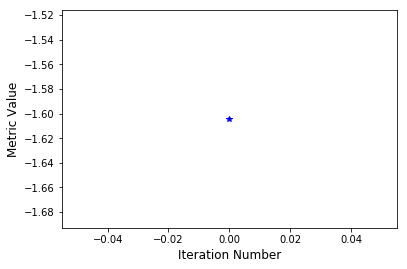

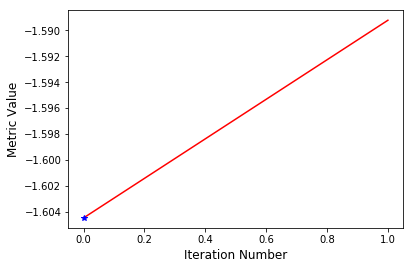

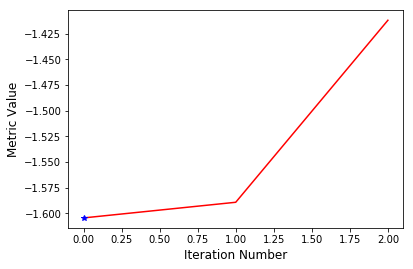

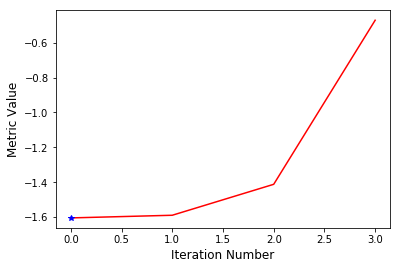

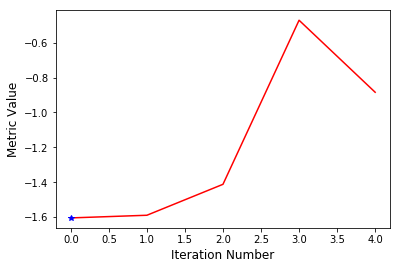

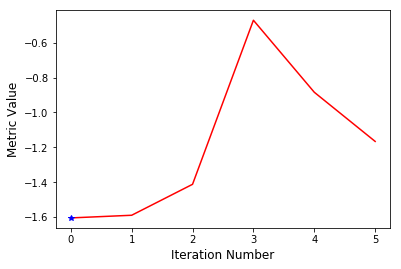

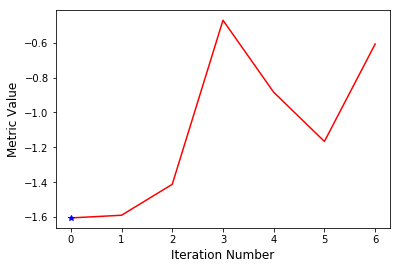

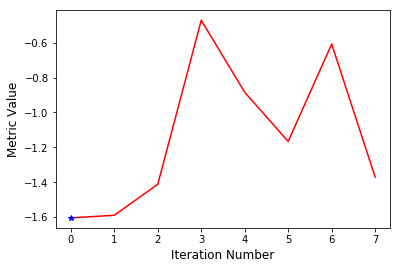

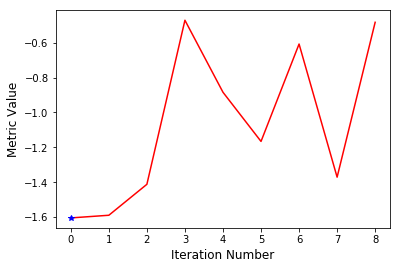

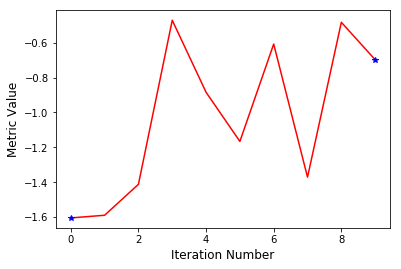

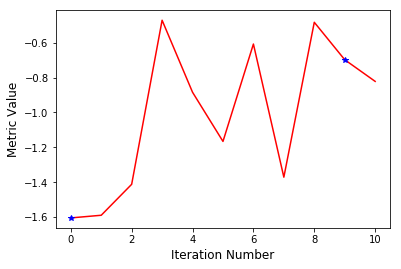

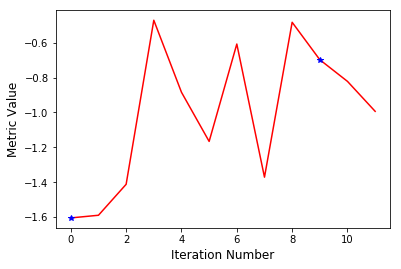

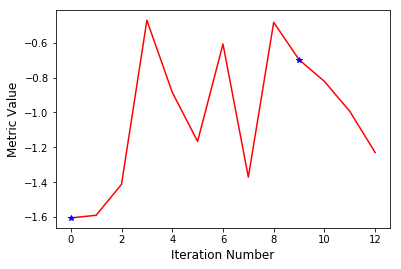

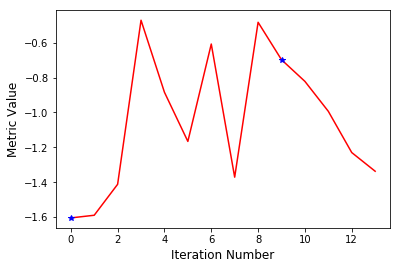

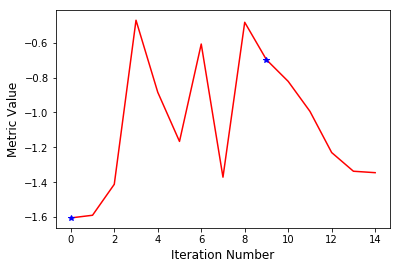

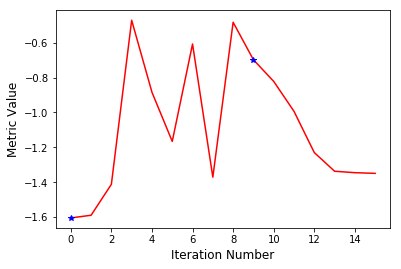

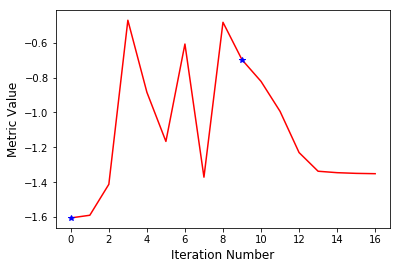

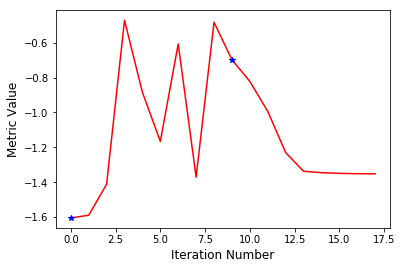

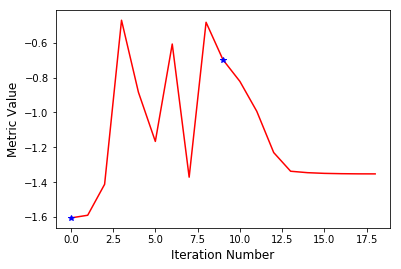

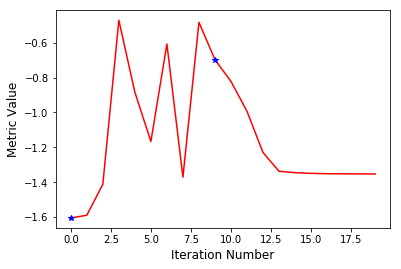

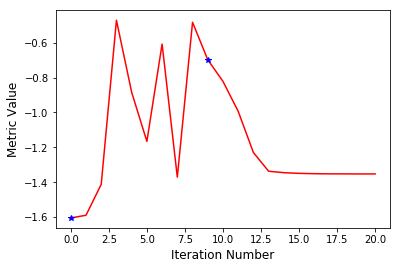

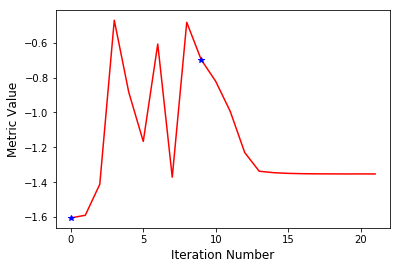

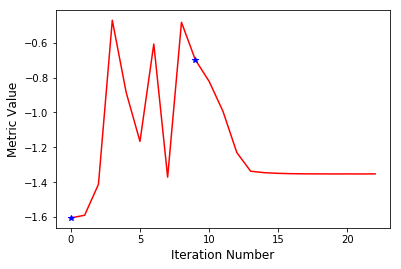

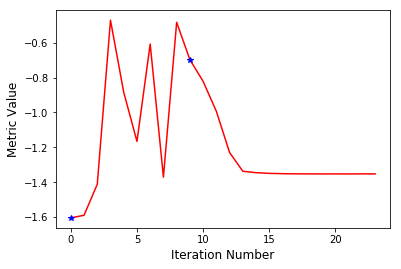

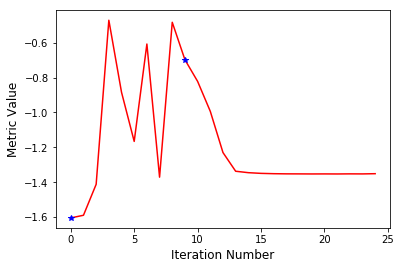

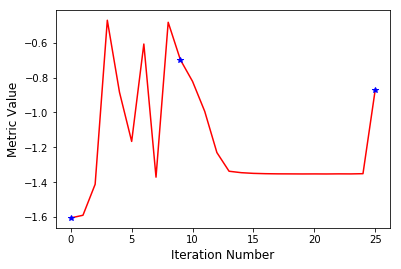

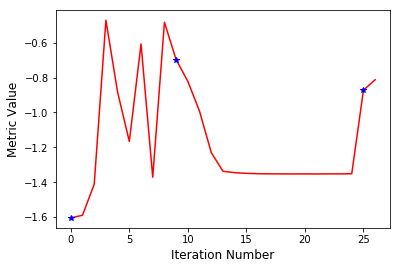

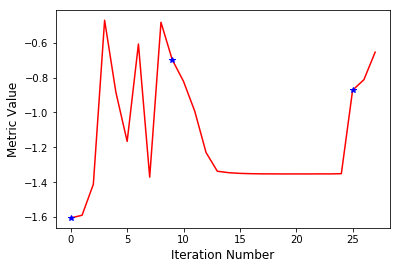

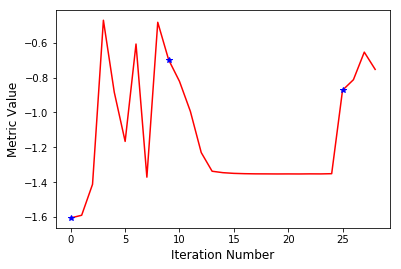

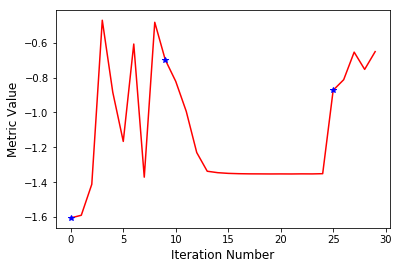

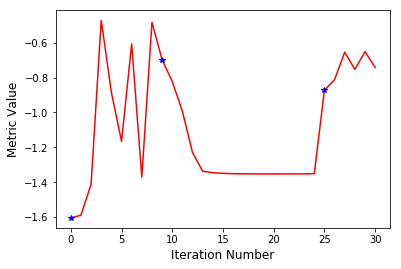

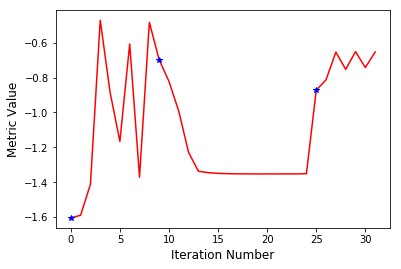

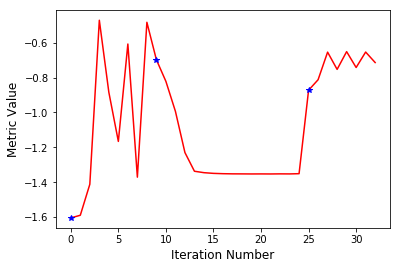

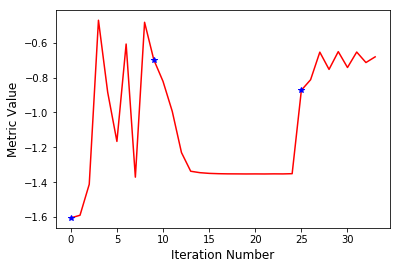

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
Final metric value: -0.6856446148144821
KneeRep_output/9404954R//TP12/002.dcm
KneeRep_output/9404954R//TP12/003.dcm
KneeRep_output/9404954R//TP12/004.dcm
KneeRep_output/9404954R//TP12/005.dcm
KneeRep_output/9404954R//TP12/006.dcm
KneeRep_output/9404954R//TP12/007.dcm
KneeRep_output/9404954R//TP12/008.dcm
KneeRep_output/9404954R//TP12/009.dcm
KneeRep_output/9404954R//TP12/010.dcm
KneeRep_output/9404954R//TP12/011.dcm
KneeRep_output/9404954R//TP12/012.dcm
KneeRep_output/9404954R//TP12/013.dcm
KneeRep_output/9404954R//TP12/014.dcm
KneeRep_output/9404954R//TP12/015.dcm
KneeRep_output/9404954R//TP12/016.dcm
KneeRep_output/9404954R//TP12/017.dcm
KneeRep_output/9404954R//TP12/018.dcm
KneeRep_output/9404954R//TP12/019.dcm
KneeRep_output/9404954R//TP12/020.dcm
KneeRep_output/9404954R//TP12/021.dcm
KneeRep_output/9404954R//TP12/022.dcm
KneeRep_output/9404954R//TP12/023.dcm
KneeRep_outpu

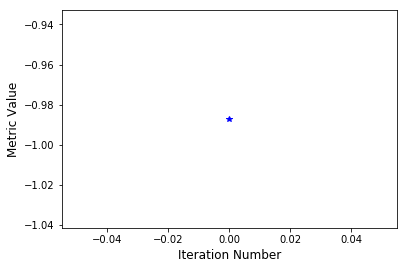

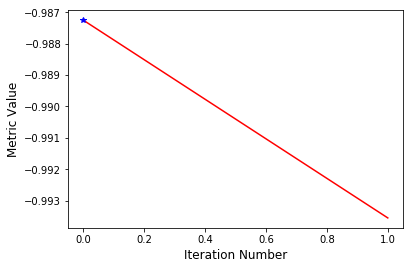

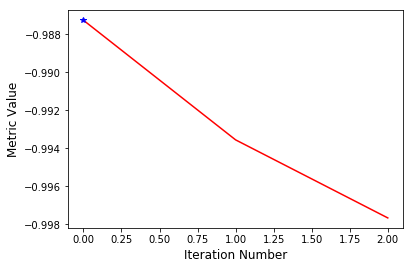

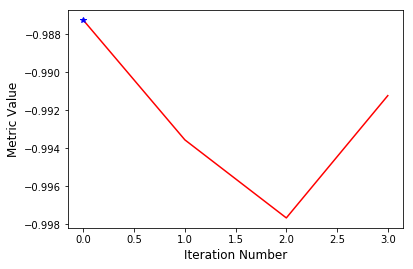

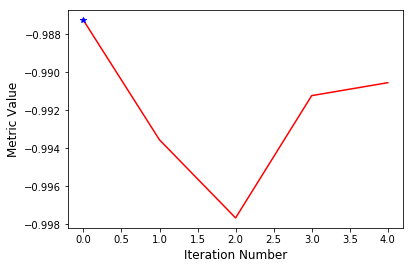

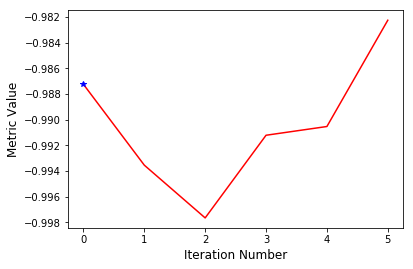

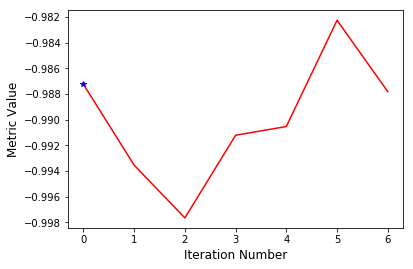

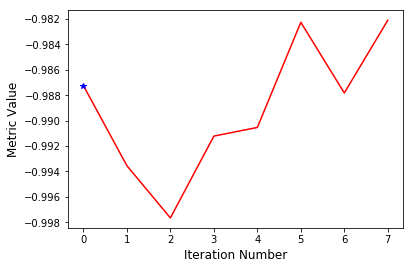

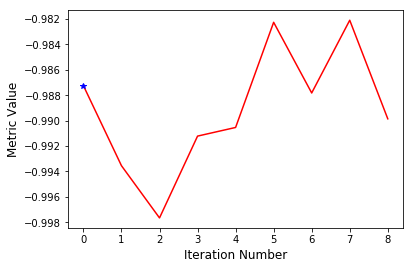

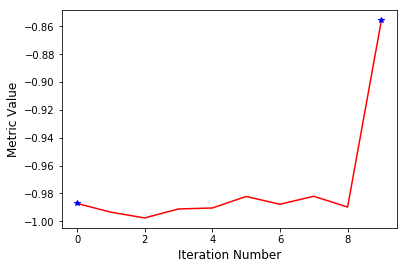

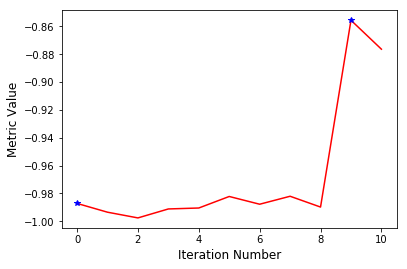

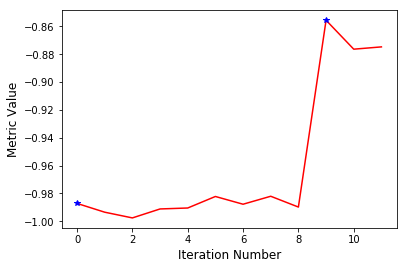

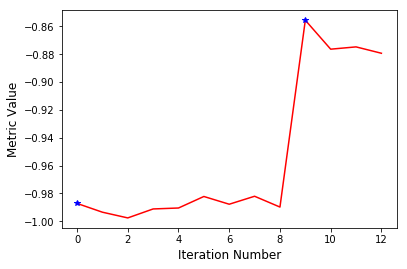

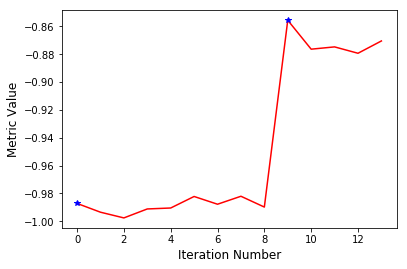

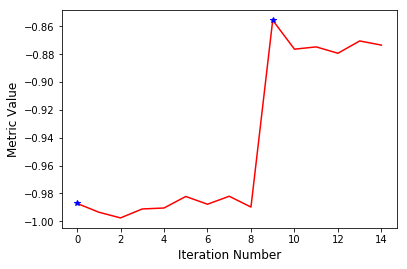

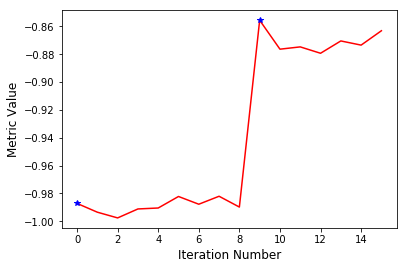

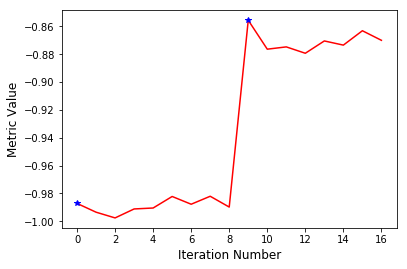

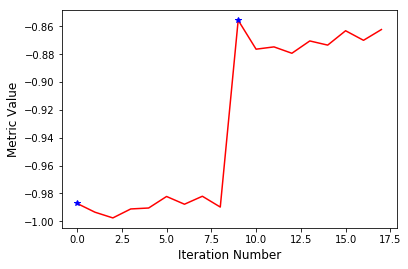

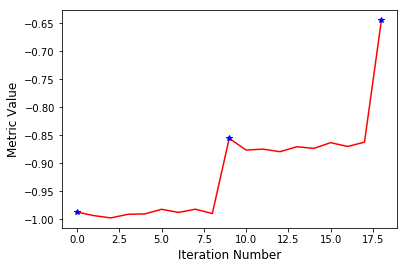

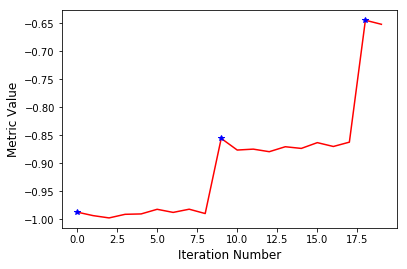

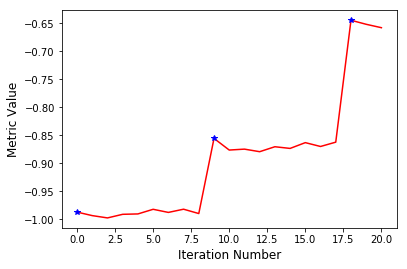

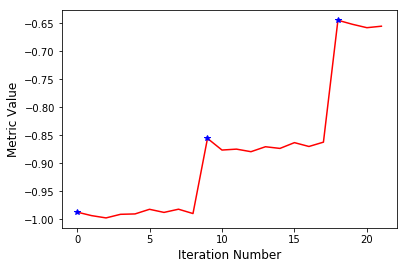

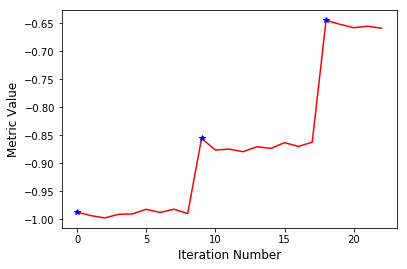

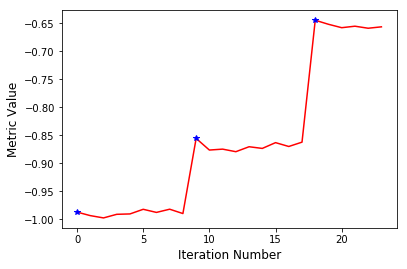

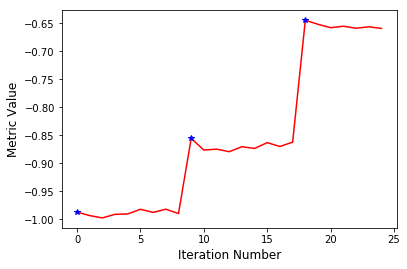

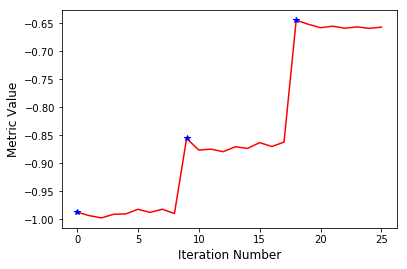

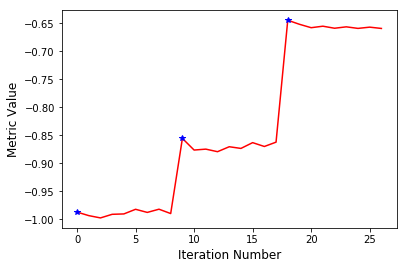

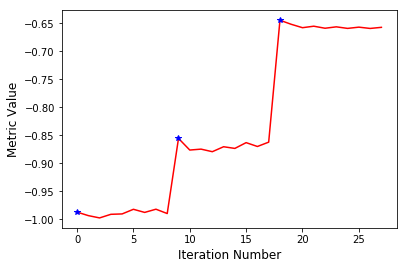

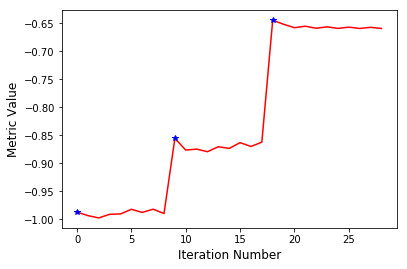

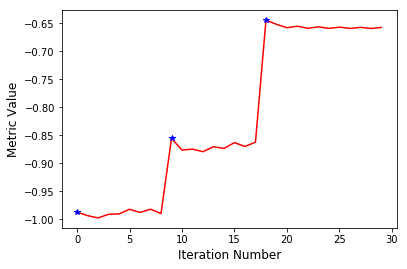

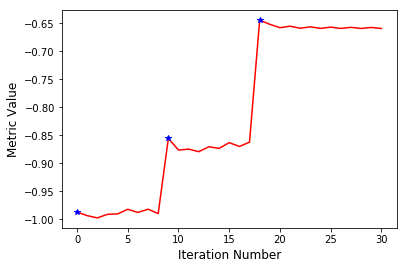

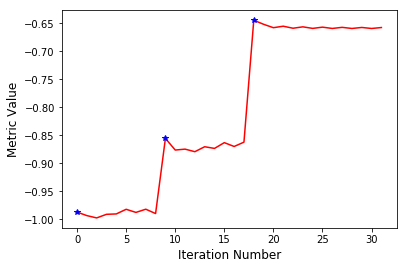

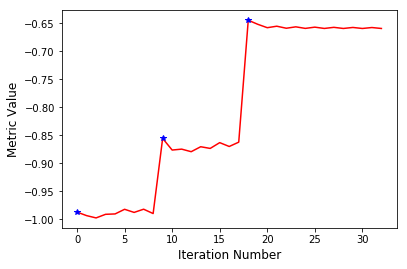

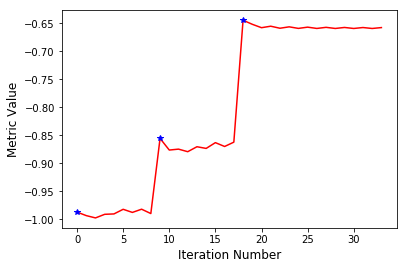

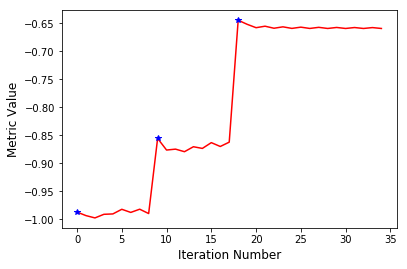

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 17.
Final metric value: -0.6576608620341979
KneeRep_output/9404954R//TP24/001.dcm
KneeRep_output/9404954R//TP24/002.dcm
KneeRep_output/9404954R//TP24/003.dcm
KneeRep_output/9404954R//TP24/004.dcm
KneeRep_output/9404954R//TP24/005.dcm
KneeRep_output/9404954R//TP24/006.dcm
KneeRep_output/9404954R//TP24/007.dcm
KneeRep_output/9404954R//TP24/008.dcm
KneeRep_output/9404954R//TP24/009.dcm
KneeRep_output/9404954R//TP24/010.dcm
KneeRep_output/9404954R//TP24/011.dcm
KneeRep_output/9404954R//TP24/012.dcm
KneeRep_output/9404954R//TP24/013.dcm
KneeRep_output/9404954R//TP24/014.dcm
KneeRep_output/9404954R//TP24/015.dcm
KneeRep_output/9404954R//TP24/016.dcm
KneeRep_output/9404954R//TP24/017.dcm
KneeRep_output/9404954R//TP24/018.dcm
KneeRep_output/9404954R//TP24/019.dcm
KneeRep_output/9404954R//TP24/020.dcm
KneeRep_output/9404954R//TP24/021.dcm
KneeRep_output/9404954R//TP24/022.dcm
KneeRep_outp

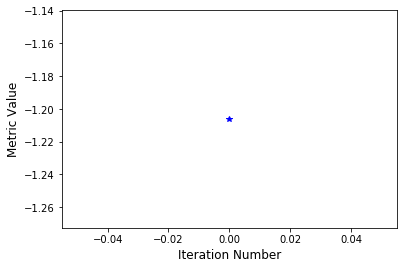

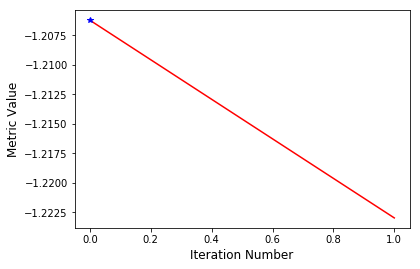

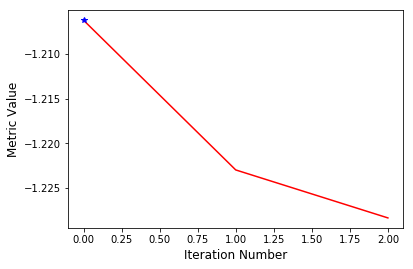

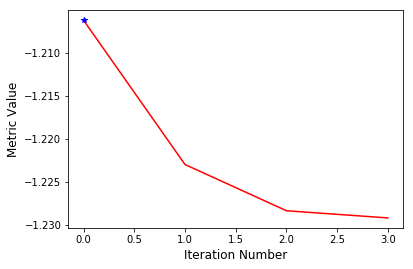

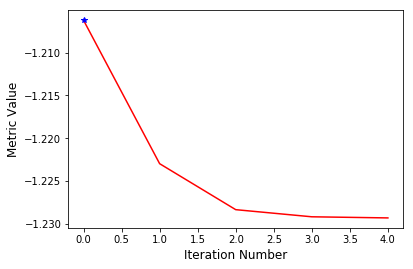

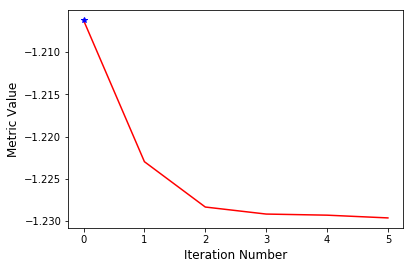

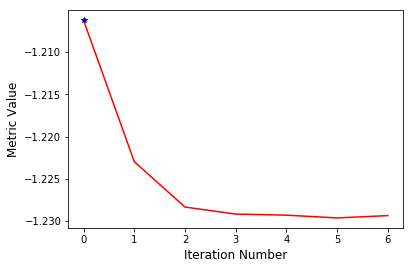

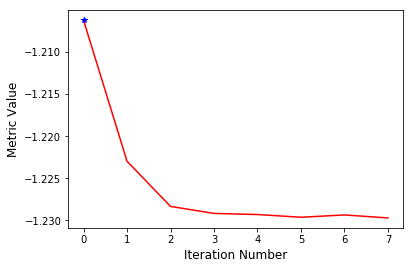

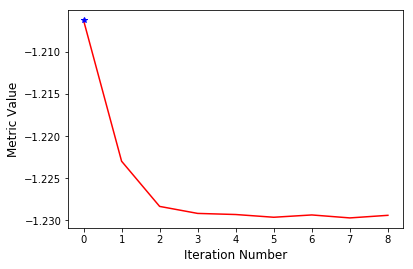

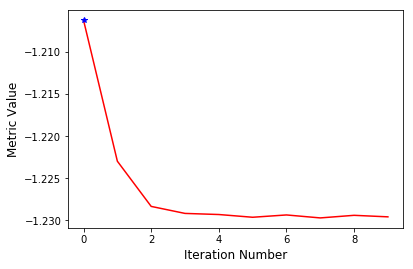

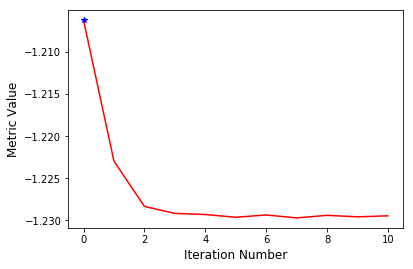

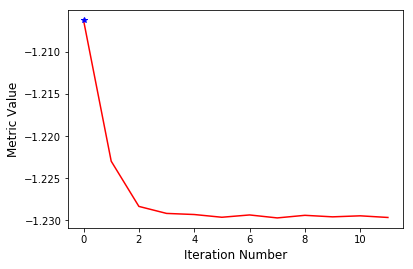

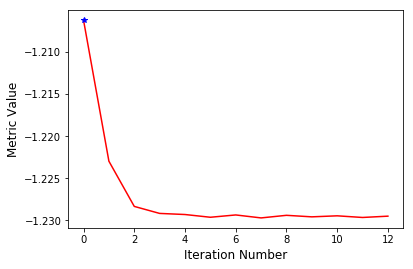

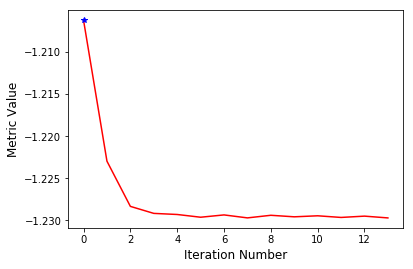

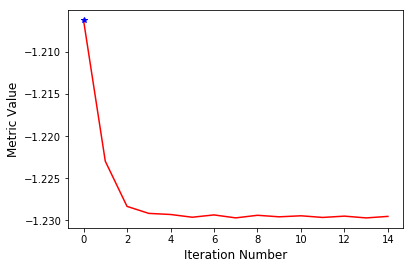

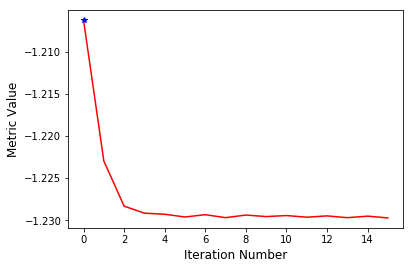

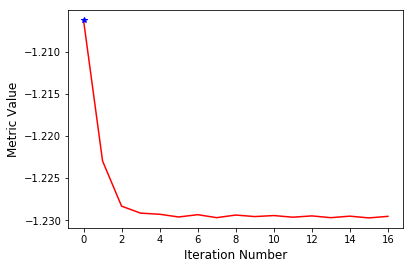

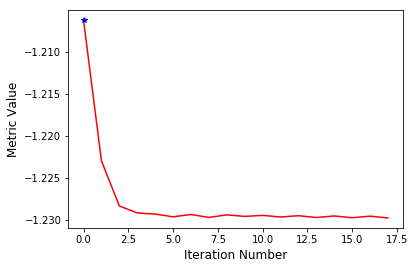

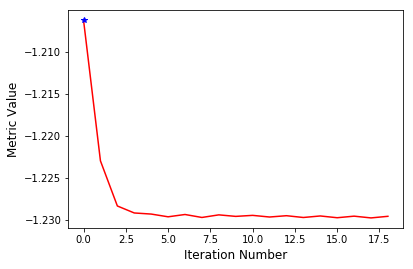

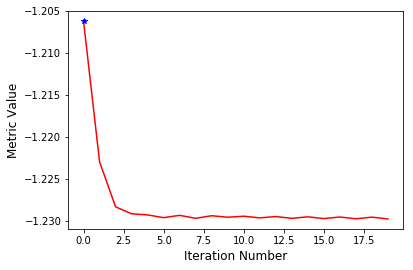

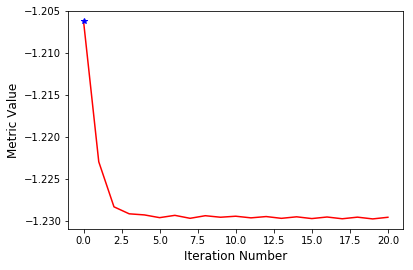

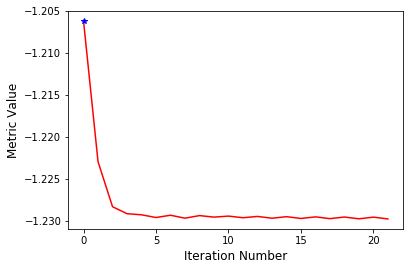

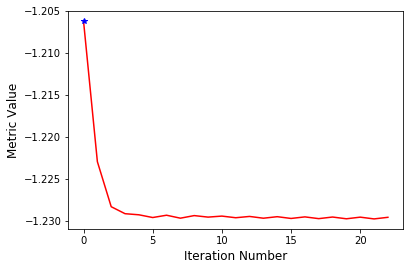

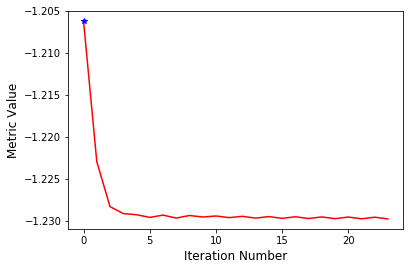

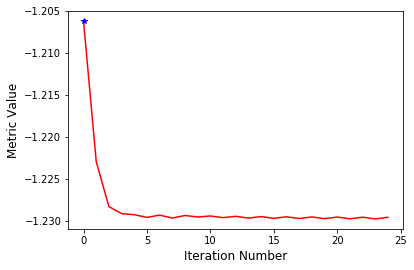

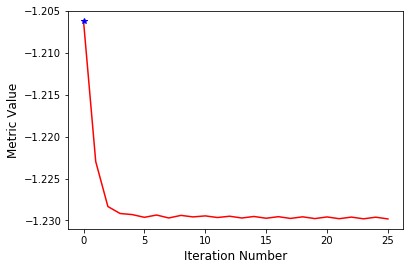

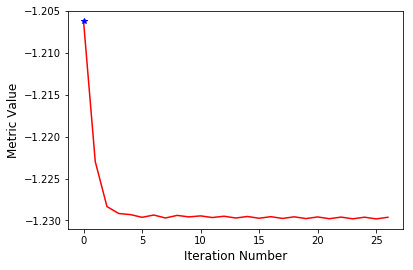

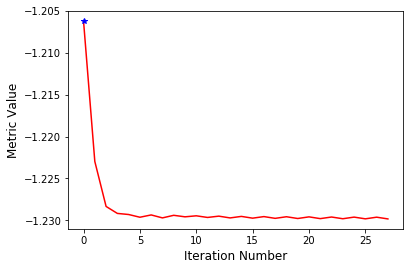

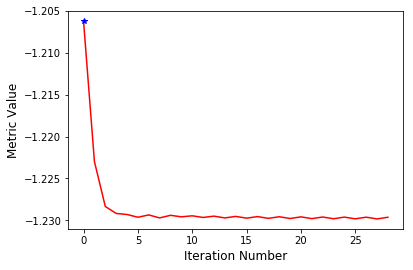

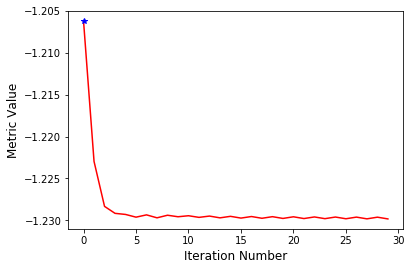

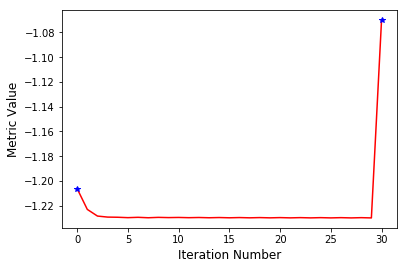

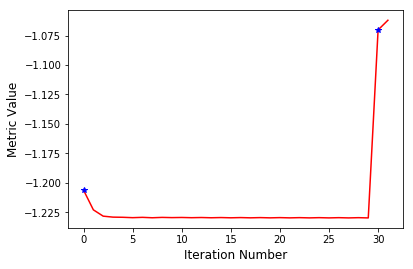

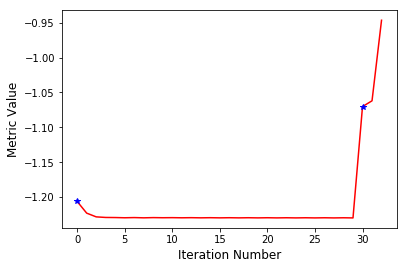

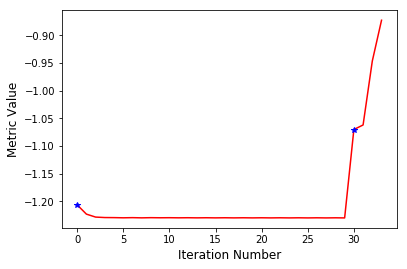

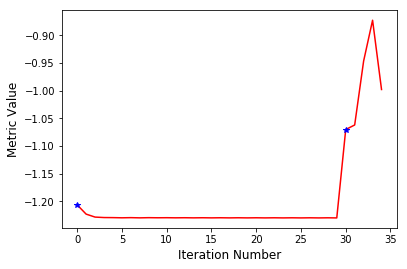

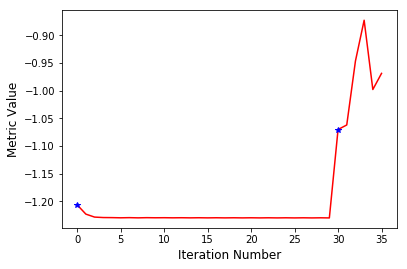

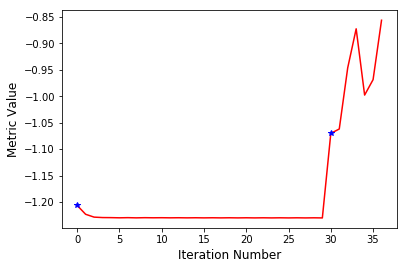

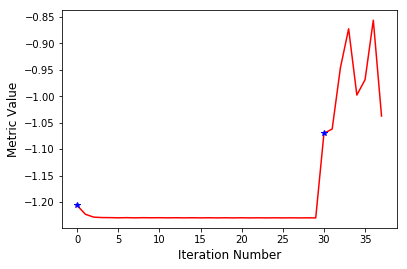

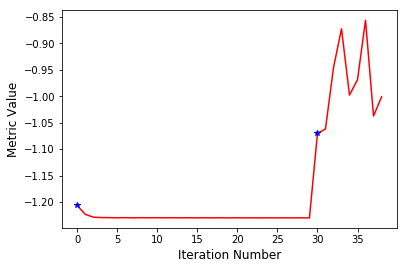

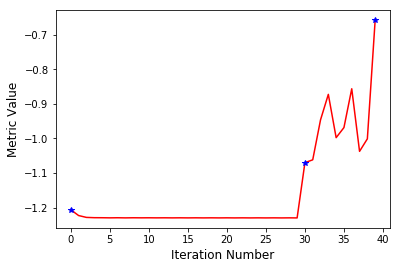

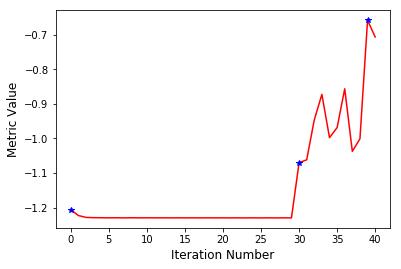

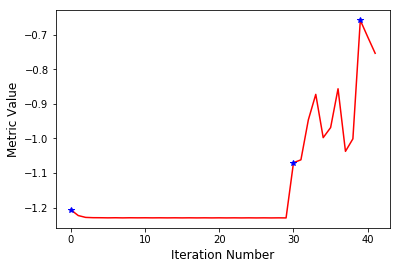

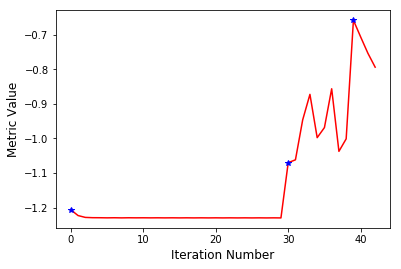

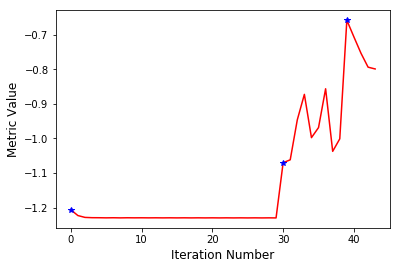

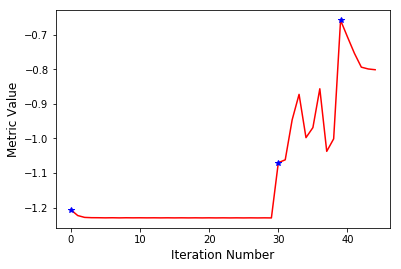

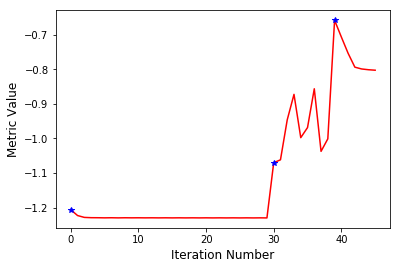

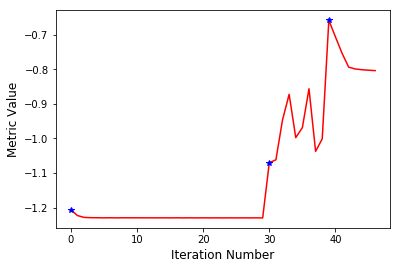

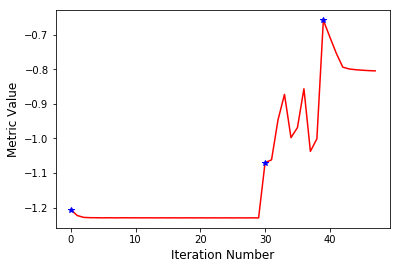

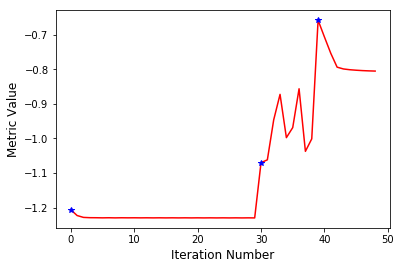

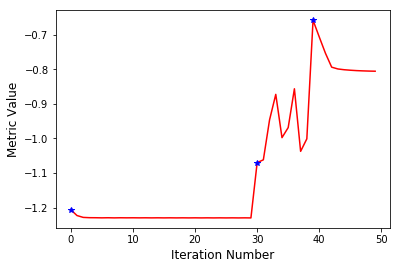

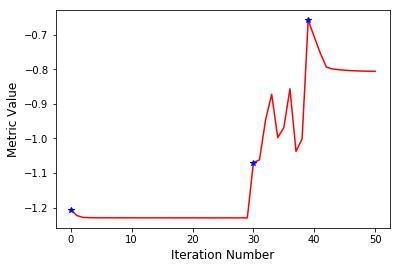

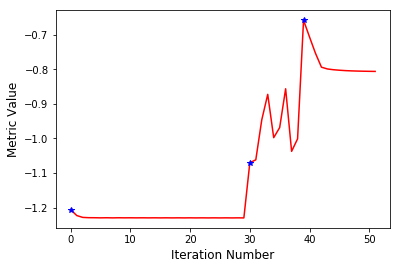

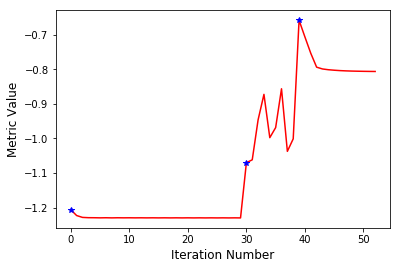

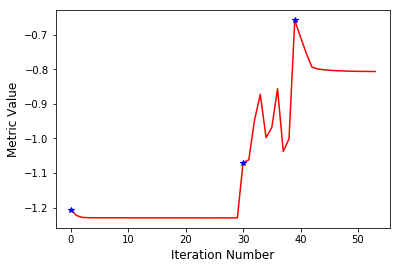

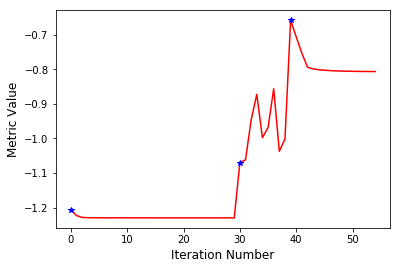

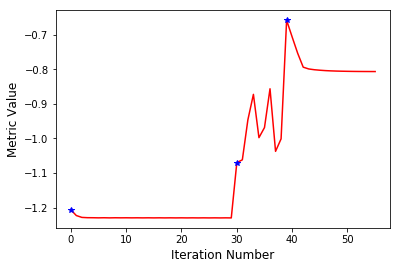

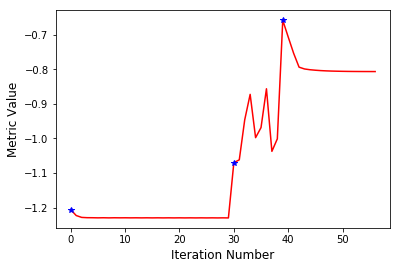

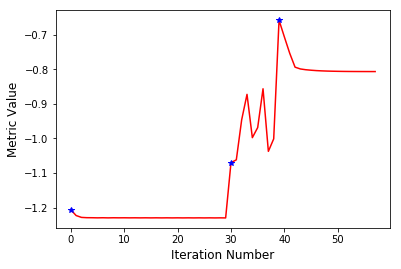

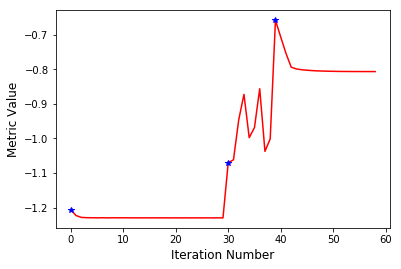

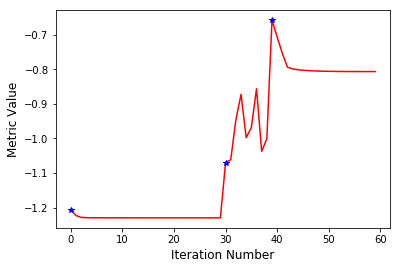

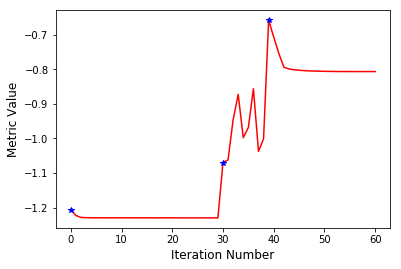

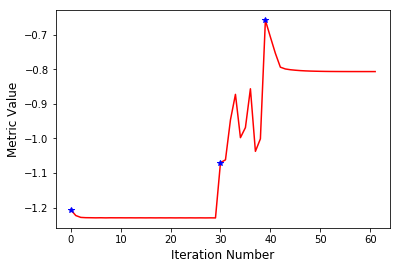

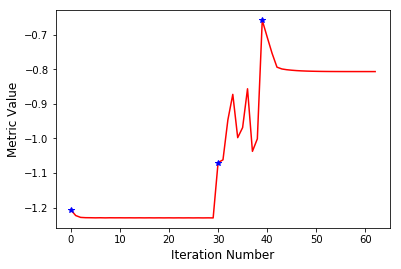

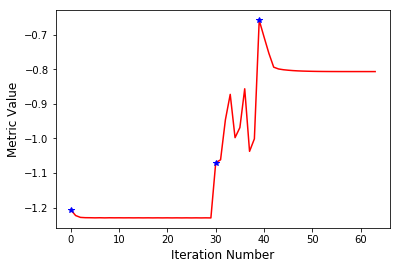

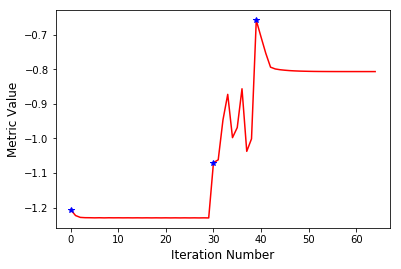

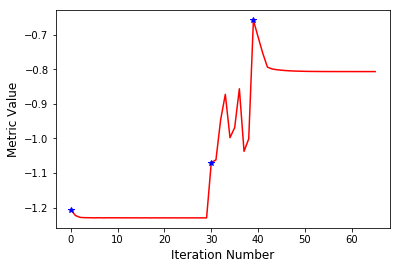

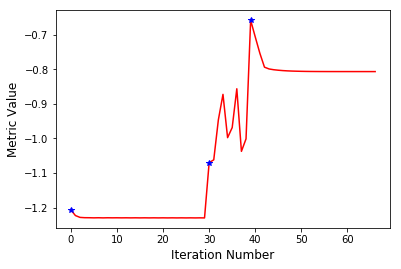

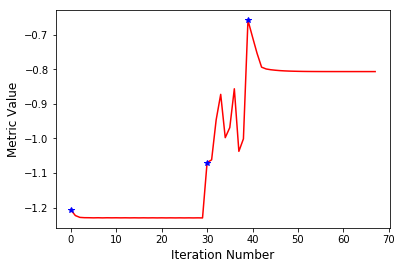

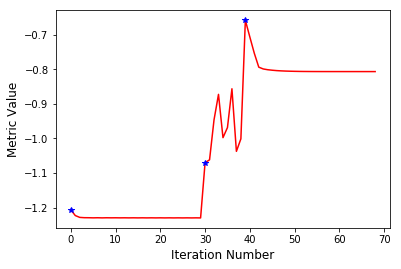

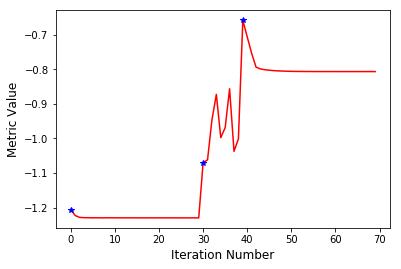

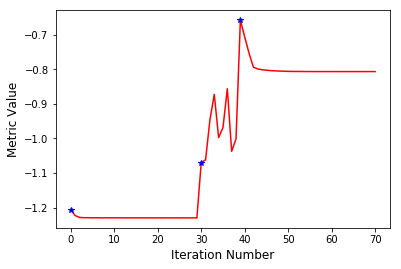

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 32.
Final metric value: -0.8069138133459172
KneeRep_output/9404954R//TP30/001.dcm
KneeRep_output/9404954R//TP30/002.dcm
KneeRep_output/9404954R//TP30/003.dcm
KneeRep_output/9404954R//TP30/004.dcm
KneeRep_output/9404954R//TP30/005.dcm
KneeRep_output/9404954R//TP30/006.dcm
KneeRep_output/9404954R//TP30/007.dcm
KneeRep_output/9404954R//TP30/008.dcm
KneeRep_output/9404954R//TP30/009.dcm
KneeRep_output/9404954R//TP30/010.dcm
KneeRep_output/9404954R//TP30/011.dcm
KneeRep_output/9404954R//TP30/012.dcm
KneeRep_output/9404954R//TP30/013.dcm
KneeRep_output/9404954R//TP30/014.dcm
KneeRep_output/9404954R//TP30/015.dcm
KneeRep_output/9404954R//TP30/016.dcm
KneeRep_output/9404954R//TP30/017.dcm
KneeRep_output/9404954R//TP30/018.dcm
KneeRep_output/9404954R//TP30/019.dcm
KneeRep_output/9404954R//TP30/020.dcm
KneeRep_output/9404954R//TP30/021.dcm
KneeRep_output/9404954R//TP30/022.dcm
KneeRep_outp

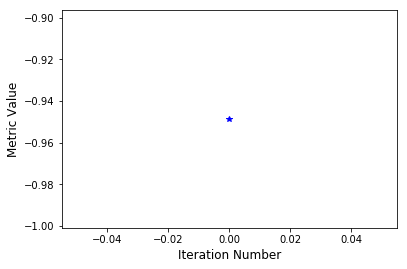

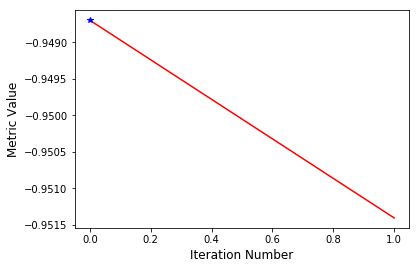

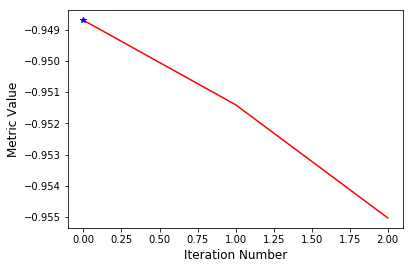

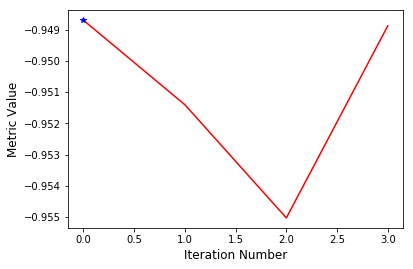

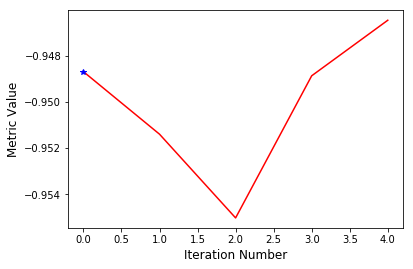

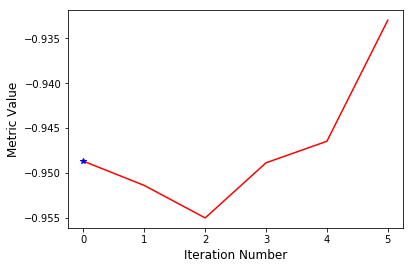

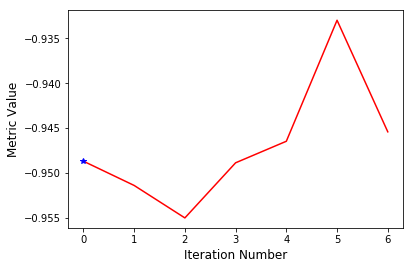

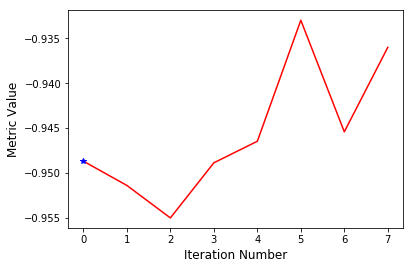

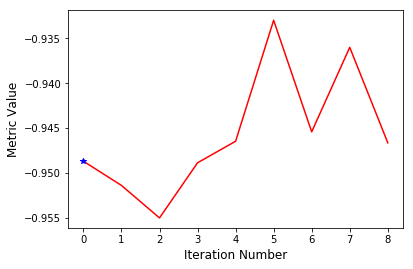

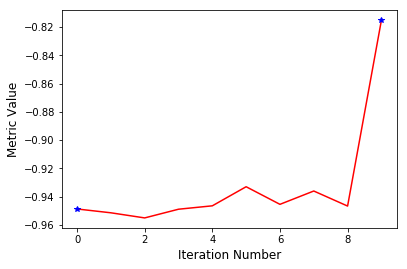

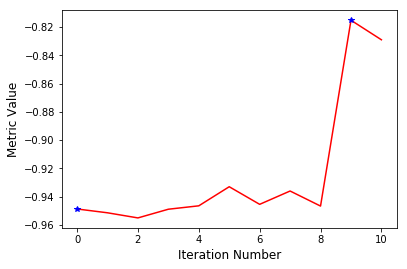

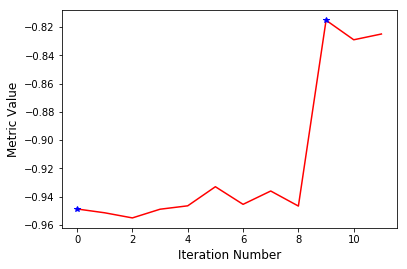

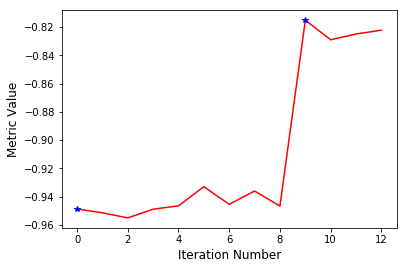

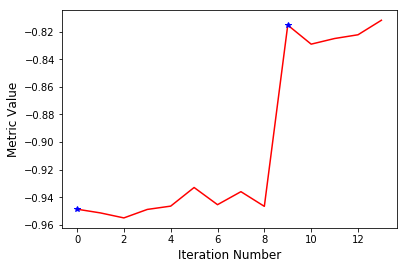

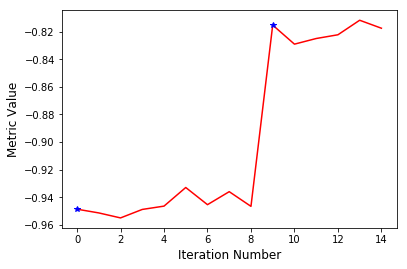

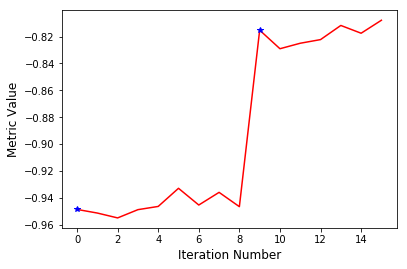

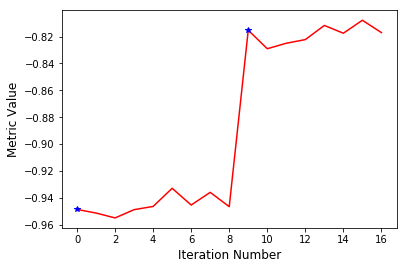

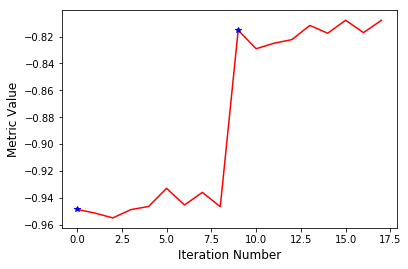

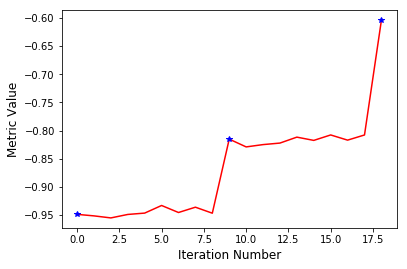

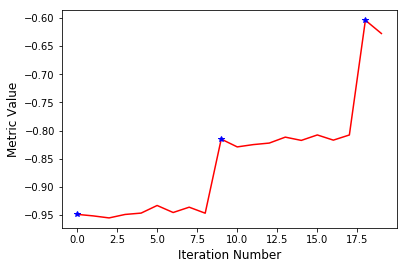

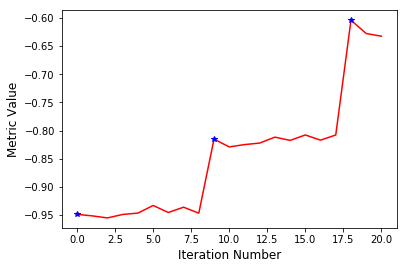

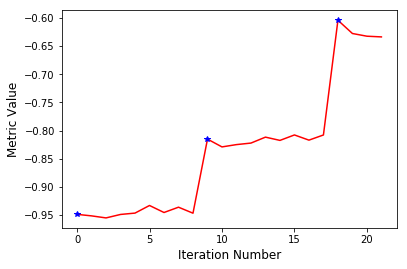

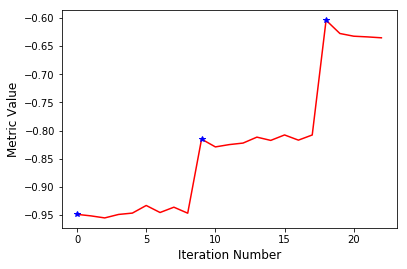

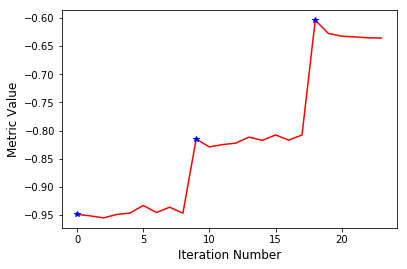

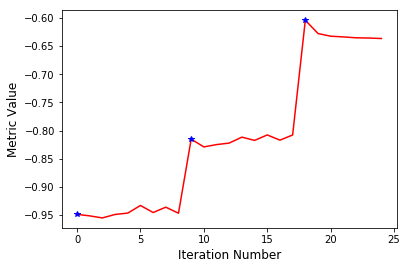

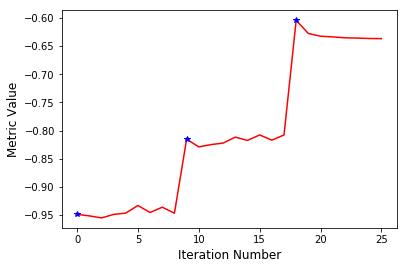

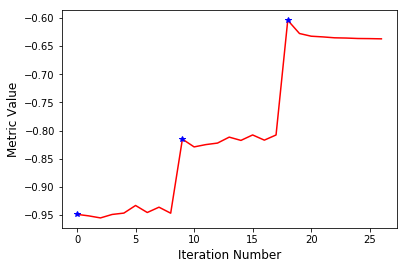

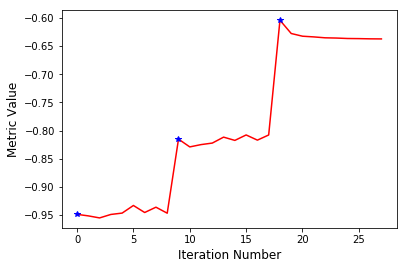

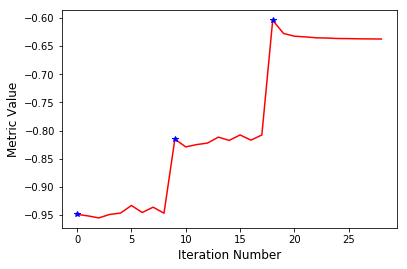

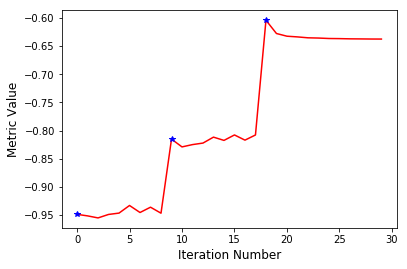

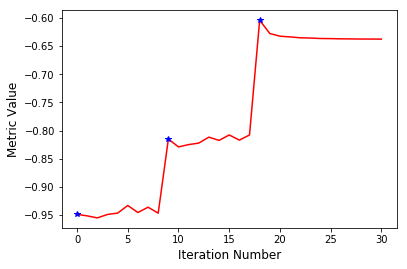

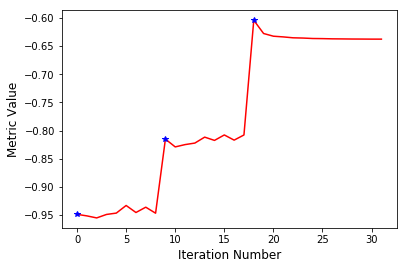

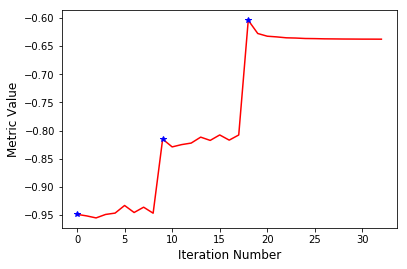

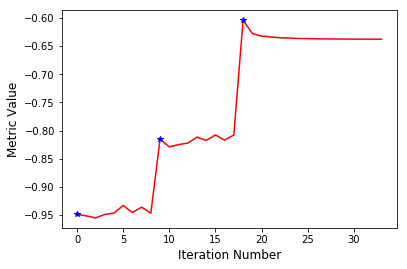

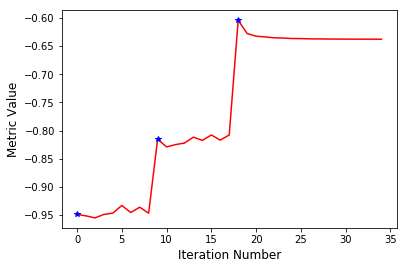

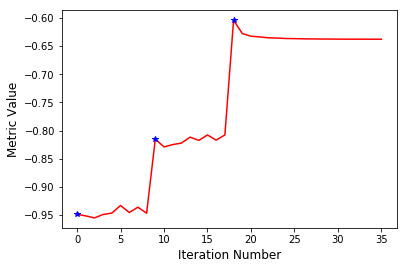

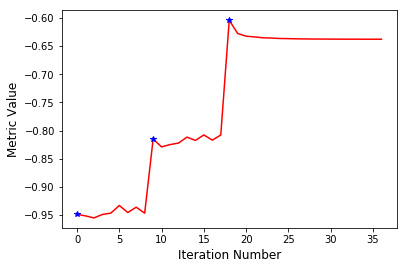

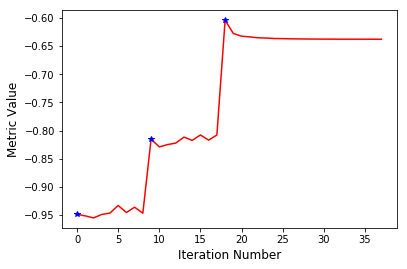

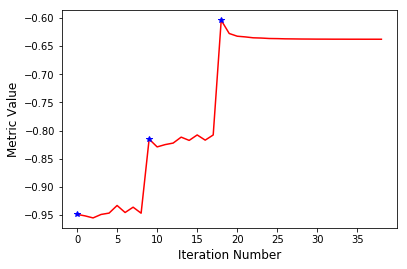

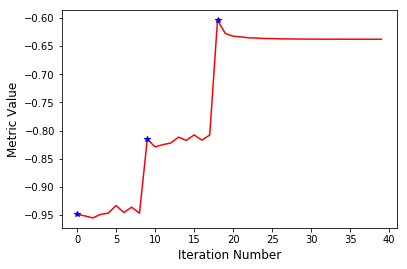

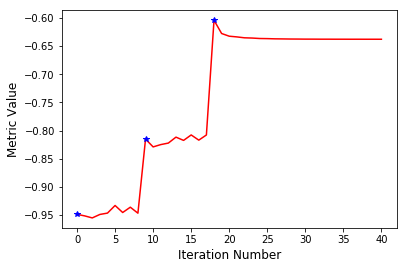

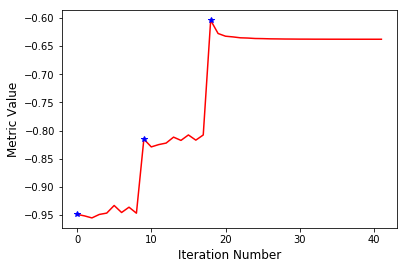

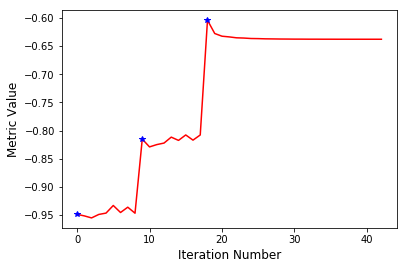

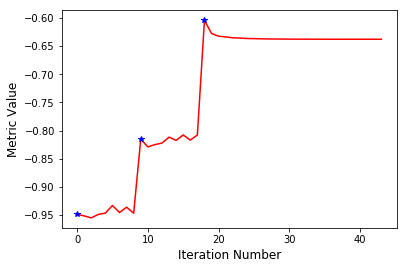

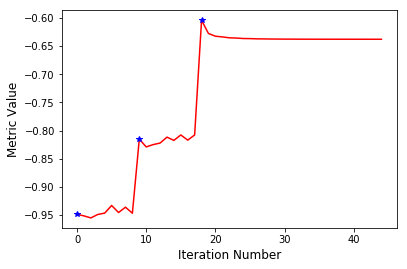

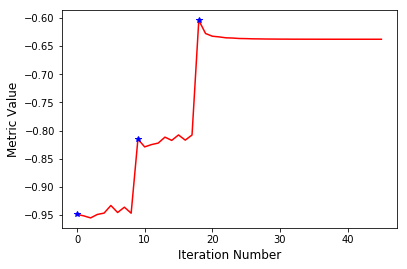

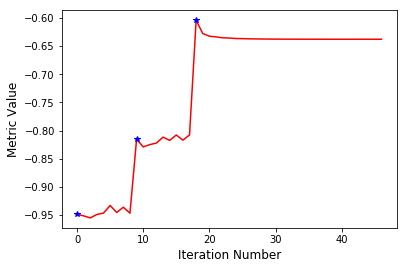

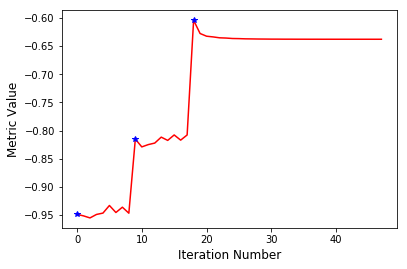

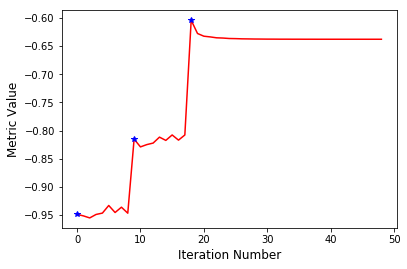

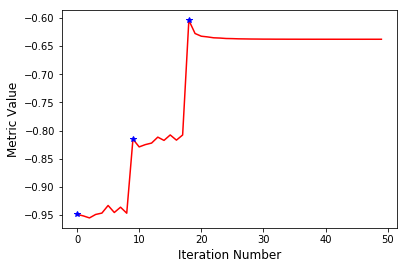

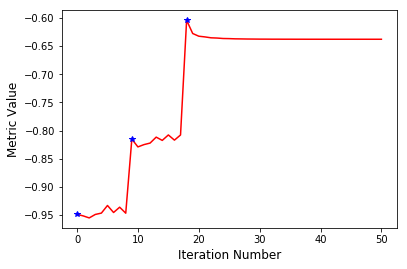

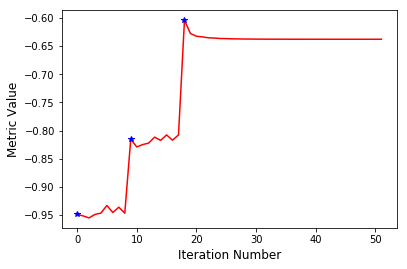

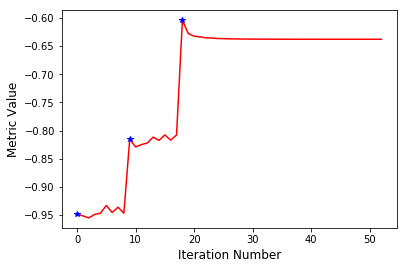

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 35.
Final metric value: -0.6379585831956572
KneeRep_output/9404954R//TP36/001.dcm
KneeRep_output/9404954R//TP36/002.dcm
KneeRep_output/9404954R//TP36/003.dcm
KneeRep_output/9404954R//TP36/004.dcm
KneeRep_output/9404954R//TP36/005.dcm
KneeRep_output/9404954R//TP36/006.dcm
KneeRep_output/9404954R//TP36/007.dcm
KneeRep_output/9404954R//TP36/008.dcm
KneeRep_output/9404954R//TP36/009.dcm
KneeRep_output/9404954R//TP36/010.dcm
KneeRep_output/9404954R//TP36/011.dcm
KneeRep_output/9404954R//TP36/012.dcm
KneeRep_output/9404954R//TP36/013.dcm
KneeRep_output/9404954R//TP36/014.dcm
KneeRep_output/9404954R//TP36/015.dcm
KneeRep_output/9404954R//TP36/016.dcm
KneeRep_output/9404954R//TP36/017.dcm
KneeRep_output/9404954R//TP36/018.dcm
KneeRep_output/9404954R//TP36/019.dcm
KneeRep_output/9404954R//TP36/020.dcm
KneeRep_output/9404954R//TP36/021.dcm
KneeRep_output/9404954R//TP36/022.dcm
KneeRep_outp

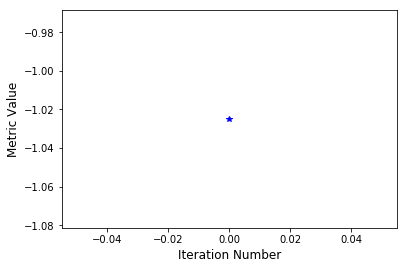

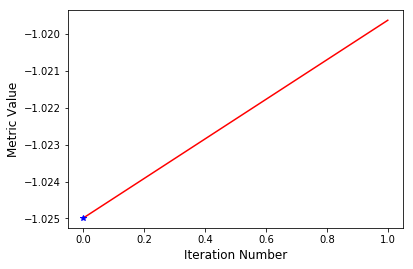

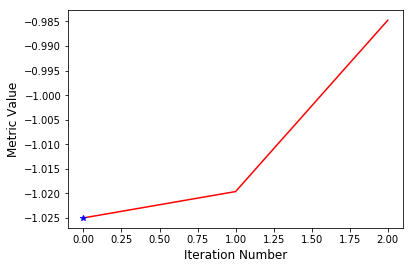

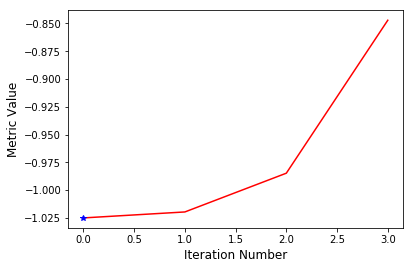

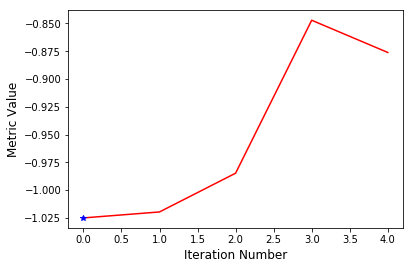

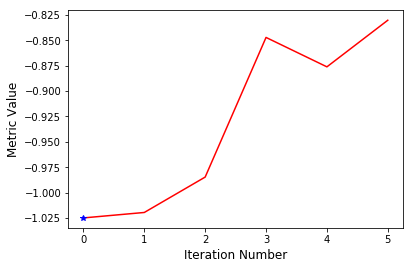

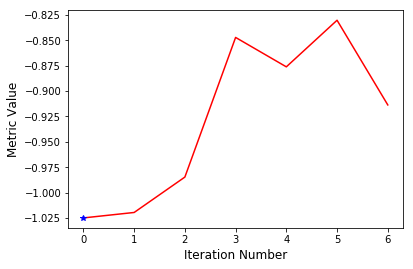

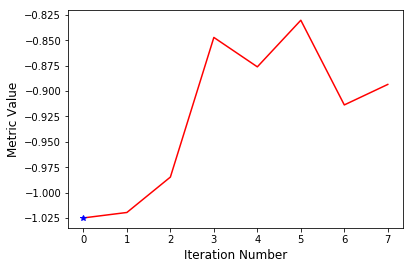

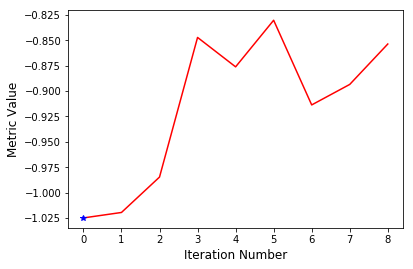

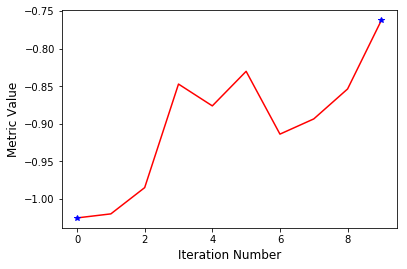

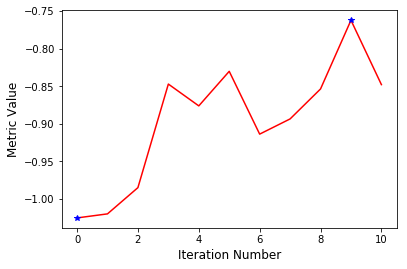

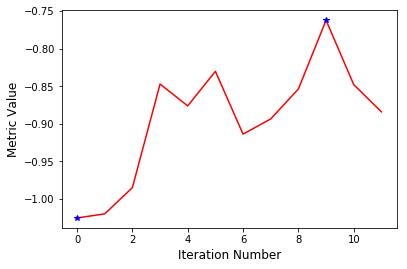

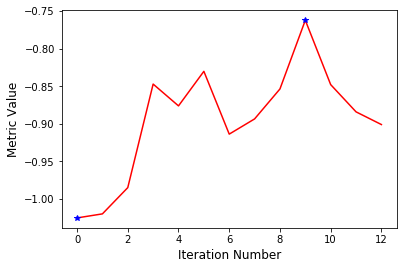

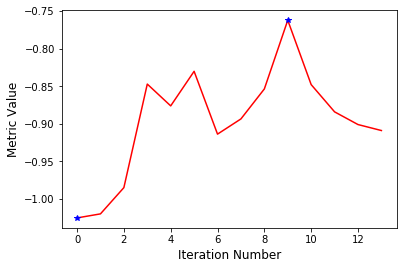

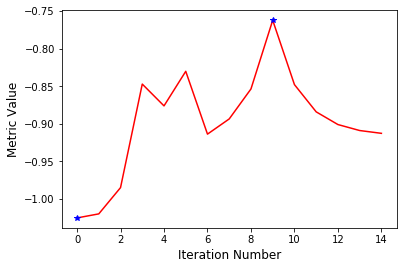

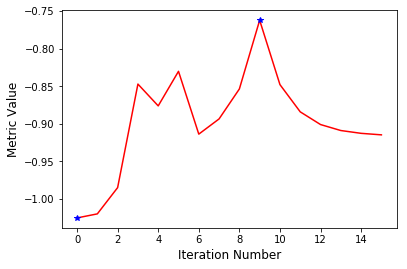

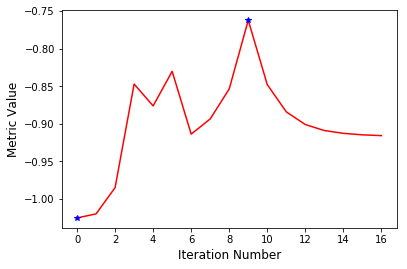

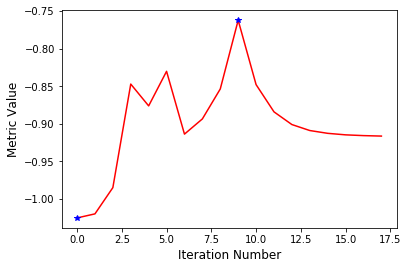

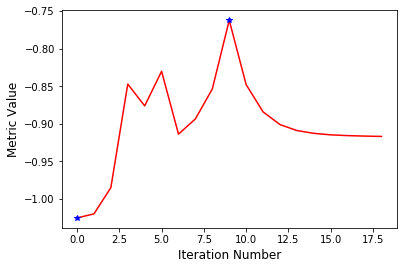

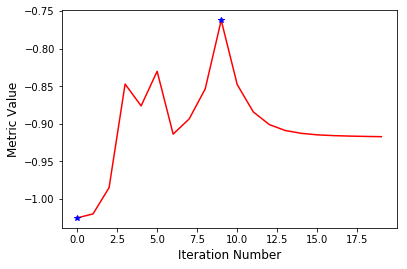

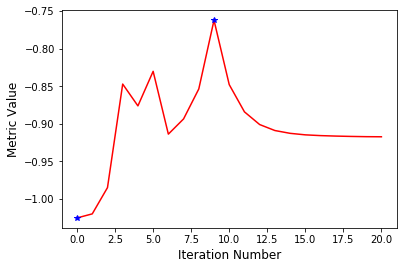

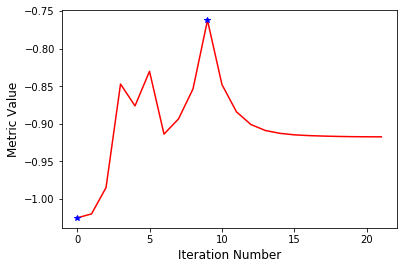

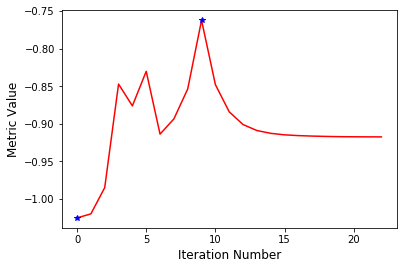

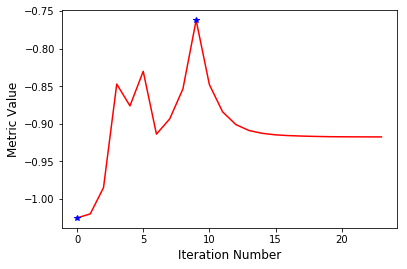

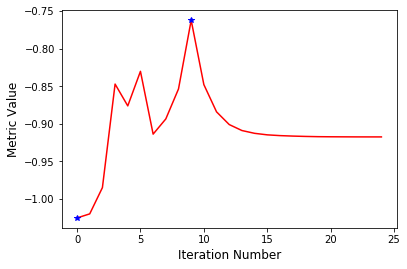

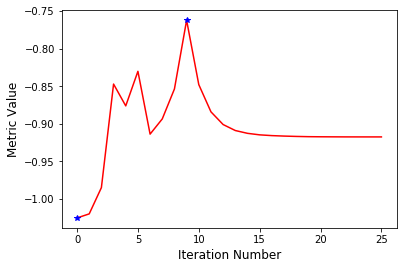

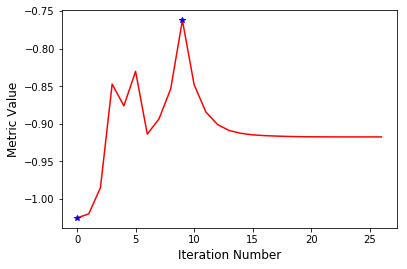

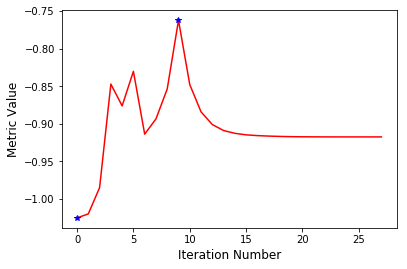

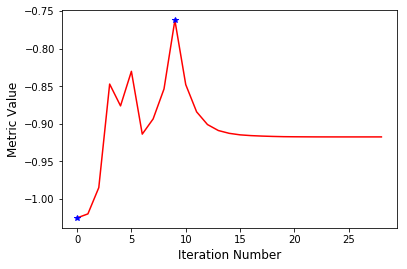

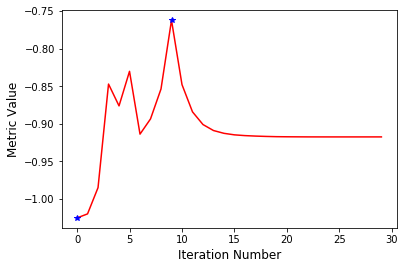

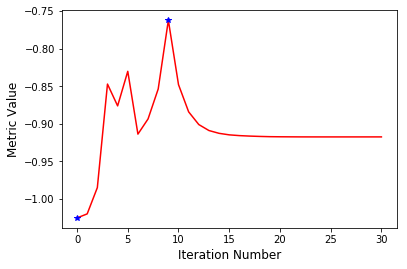

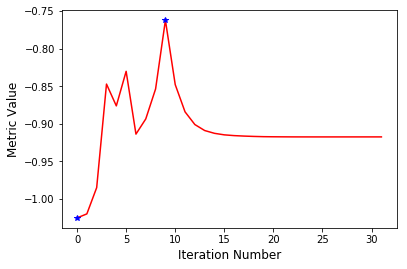

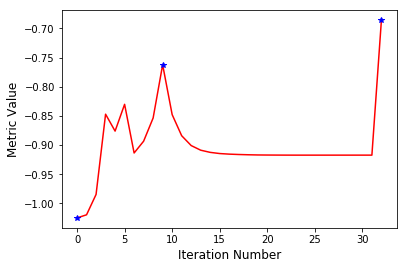

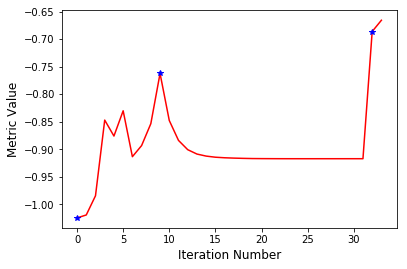

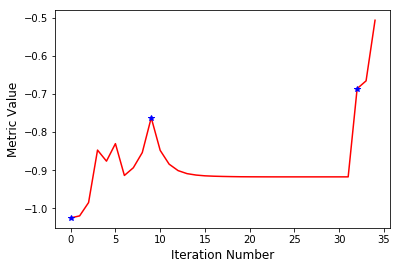

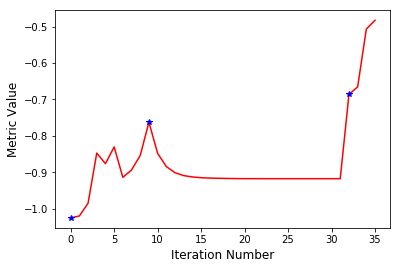

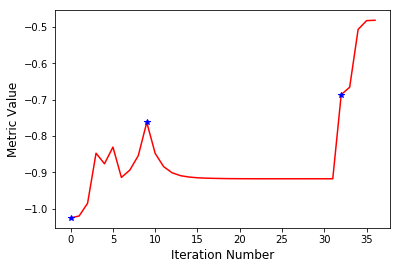

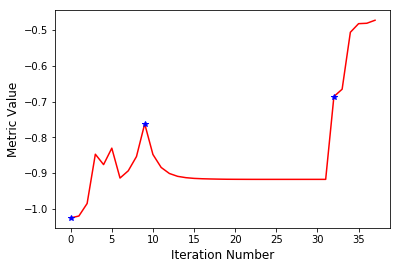

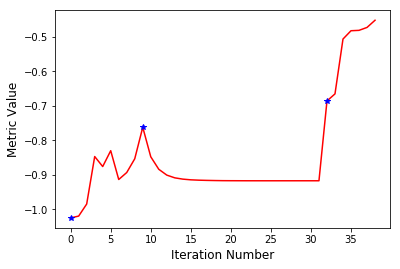

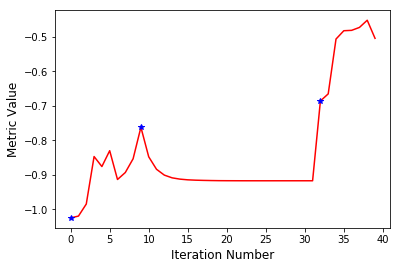

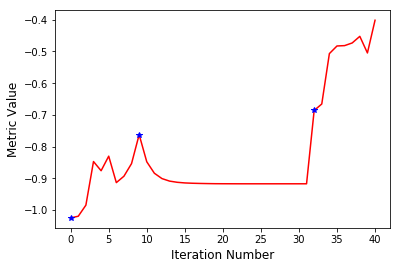

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
Final metric value: -0.6355900432982405
KneeRep_output/9404954R//TP48/001.dcm
KneeRep_output/9404954R//TP48/002.dcm
KneeRep_output/9404954R//TP48/003.dcm
KneeRep_output/9404954R//TP48/004.dcm
KneeRep_output/9404954R//TP48/005.dcm
KneeRep_output/9404954R//TP48/006.dcm
KneeRep_output/9404954R//TP48/007.dcm
KneeRep_output/9404954R//TP48/008.dcm
KneeRep_output/9404954R//TP48/009.dcm
KneeRep_output/9404954R//TP48/010.dcm
KneeRep_output/9404954R//TP48/011.dcm
KneeRep_output/9404954R//TP48/012.dcm
KneeRep_output/9404954R//TP48/013.dcm
KneeRep_output/9404954R//TP48/014.dcm
KneeRep_output/9404954R//TP48/015.dcm
KneeRep_output/9404954R//TP48/016.dcm
KneeRep_output/9404954R//TP48/017.dcm
KneeRep_output/9404954R//TP48/018.dcm
KneeRep_output/9404954R//TP48/019.dcm
KneeRep_output/9404954R//TP48/020.dcm
KneeRep_output/9404954R//TP48/021.dcm
KneeRep_output/9404954R//TP48/022.dcm
KneeRep_outpu

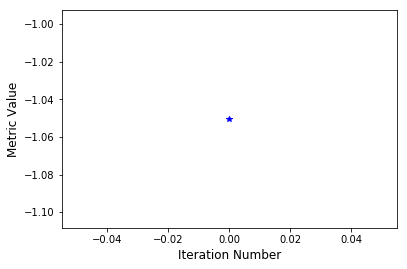

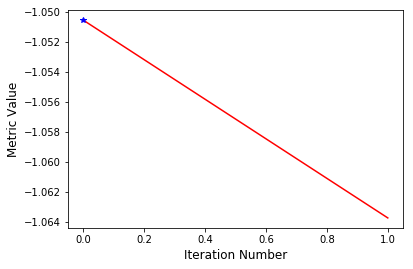

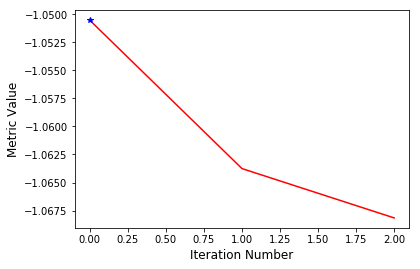

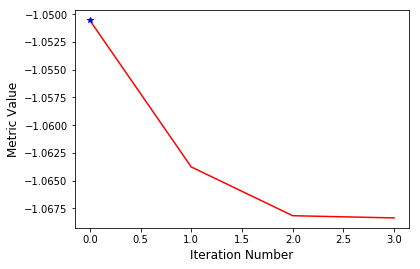

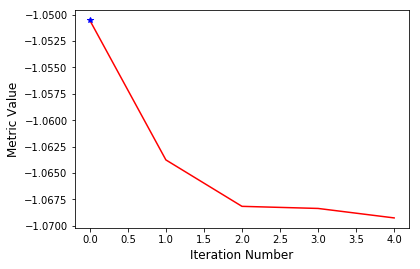

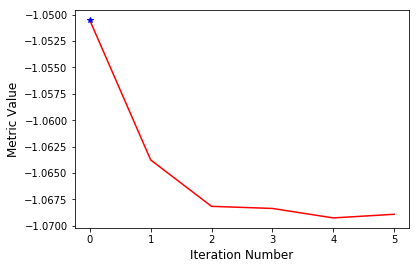

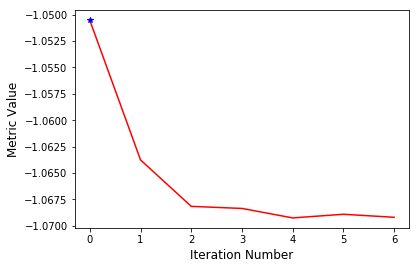

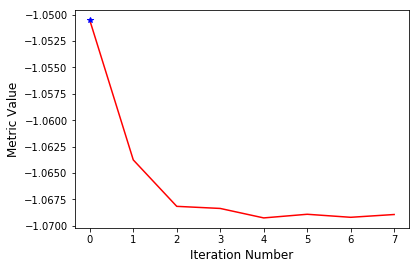

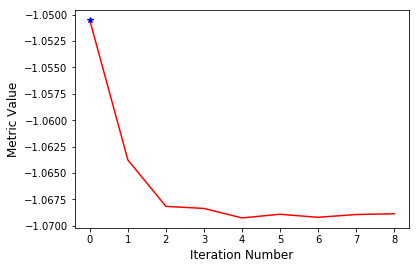

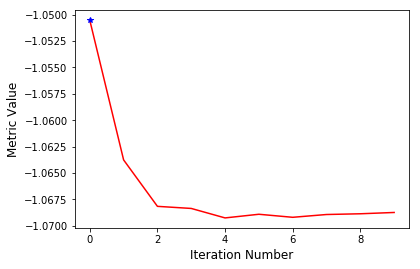

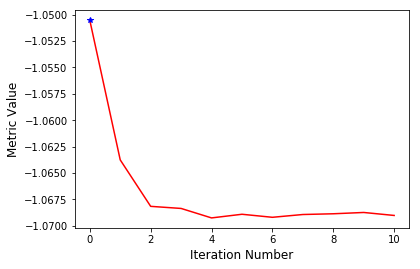

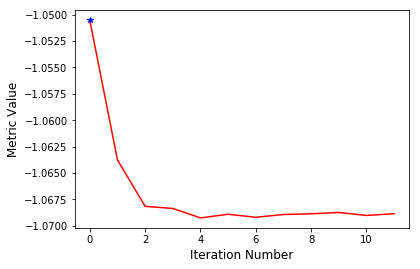

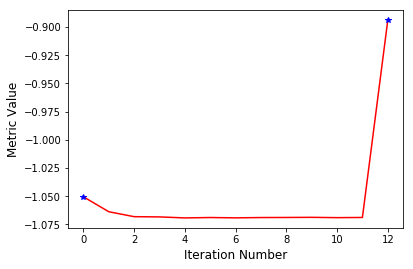

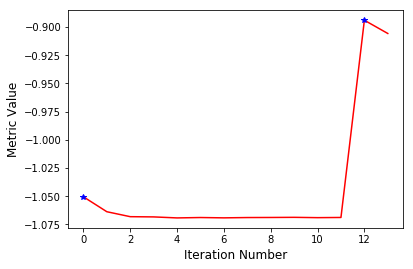

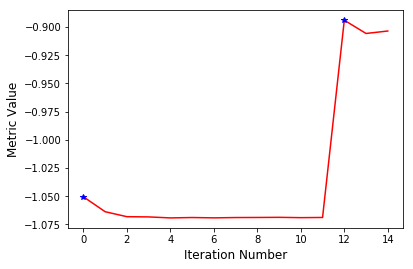

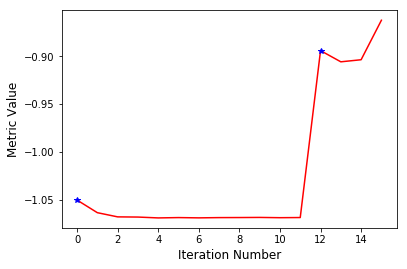

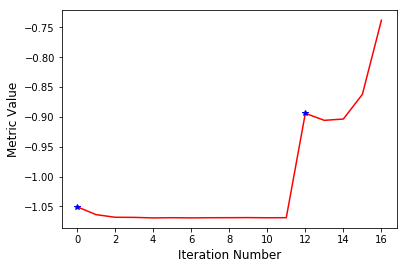

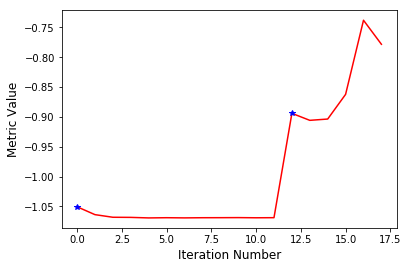

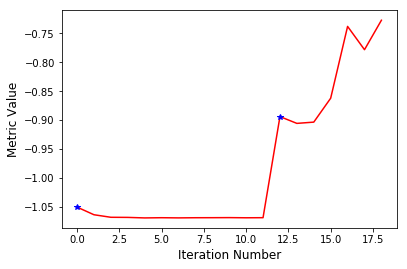

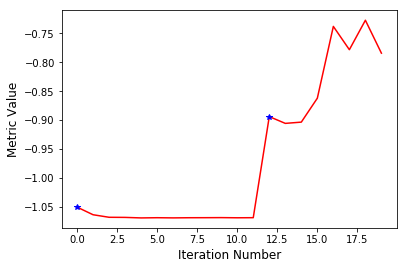

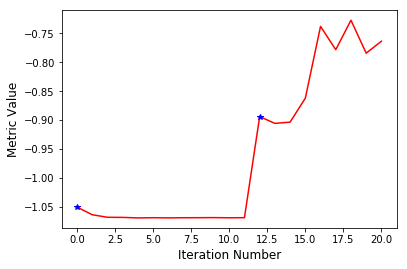

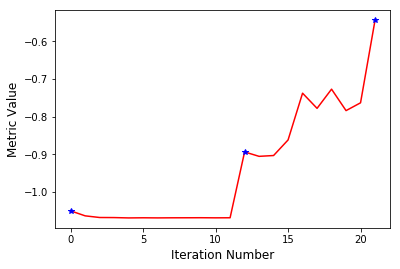

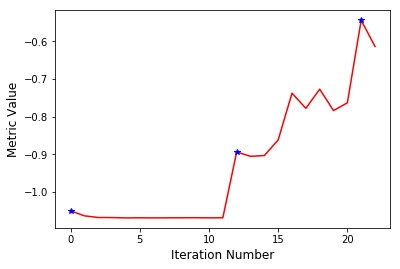

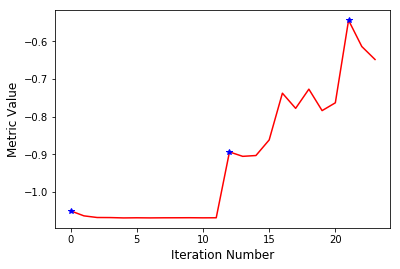

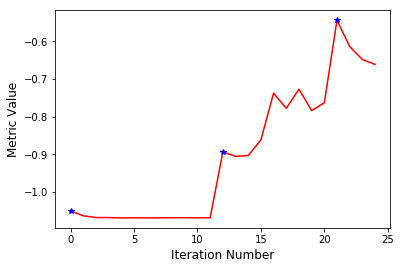

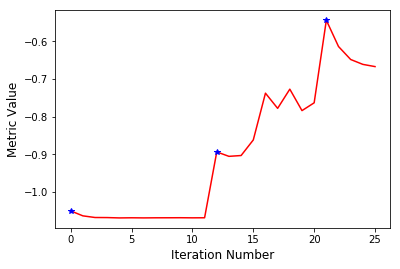

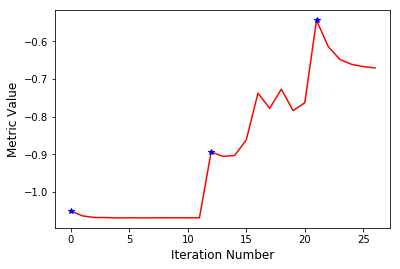

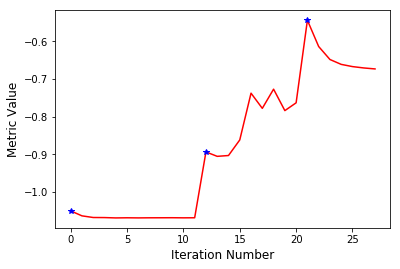

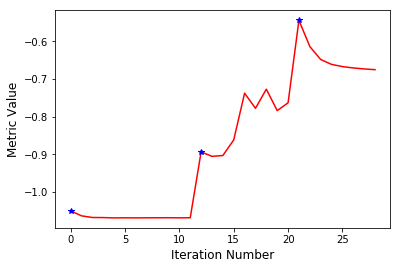

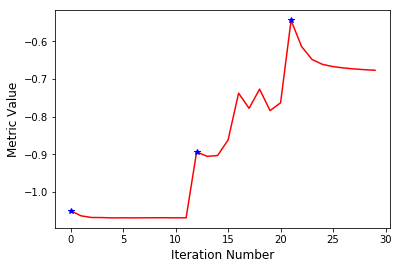

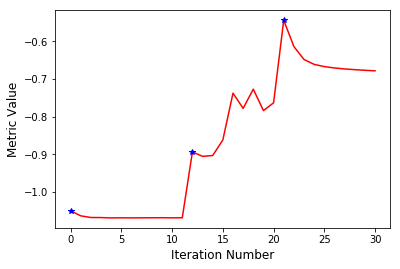

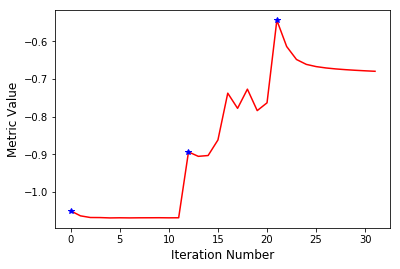

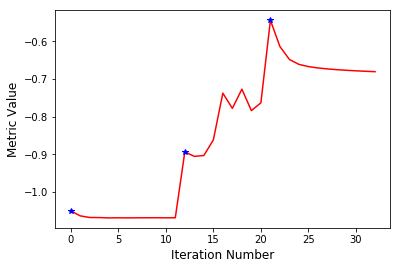

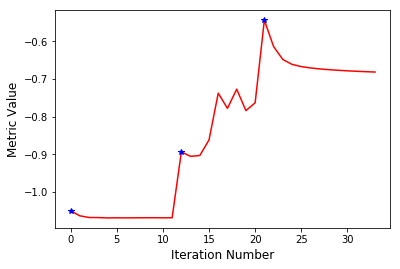

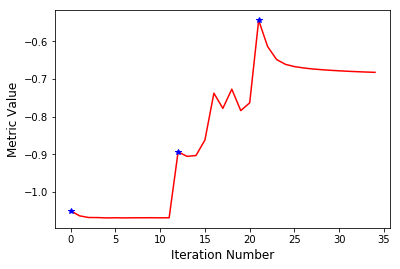

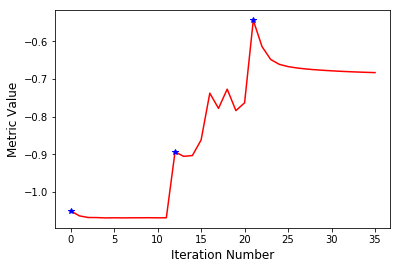

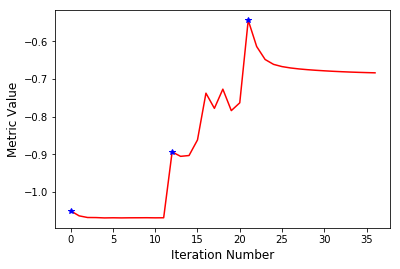

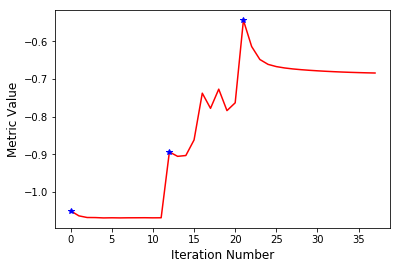

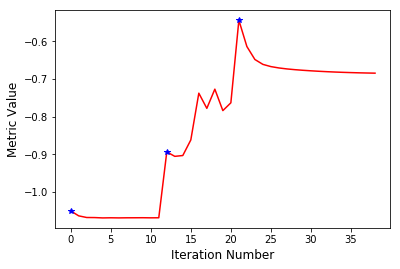

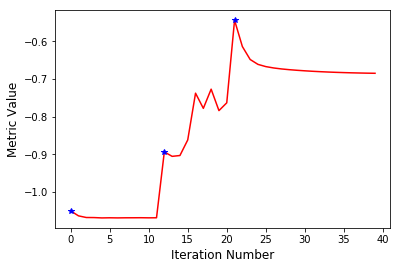

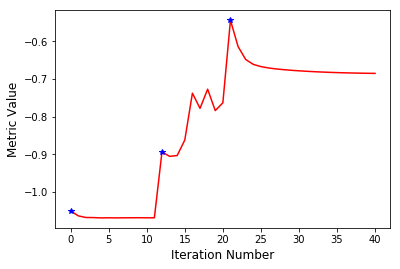

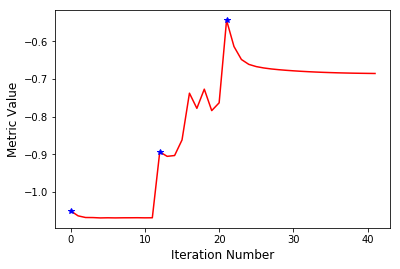

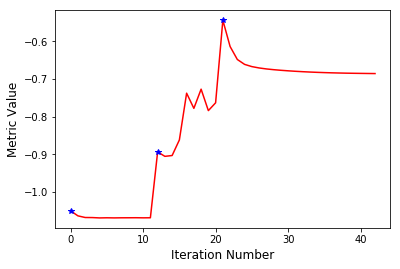

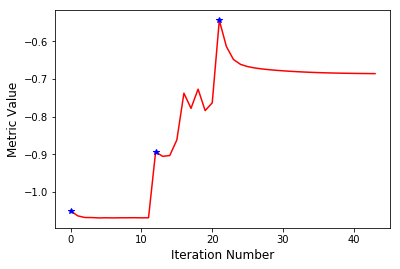

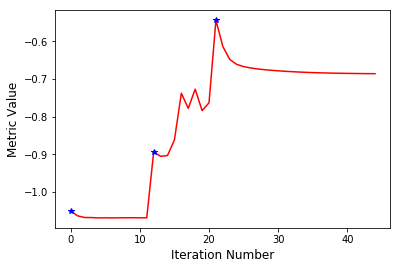

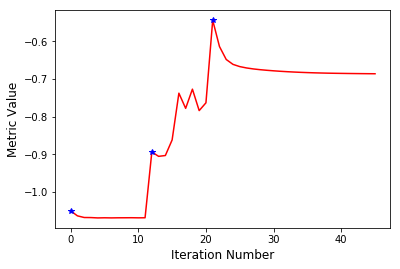

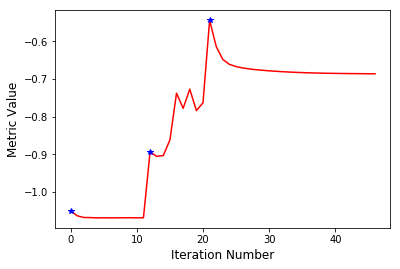

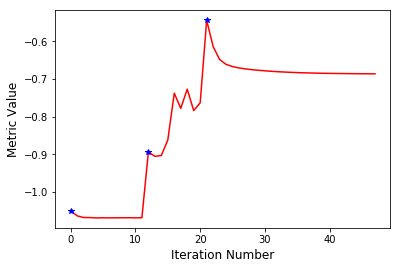

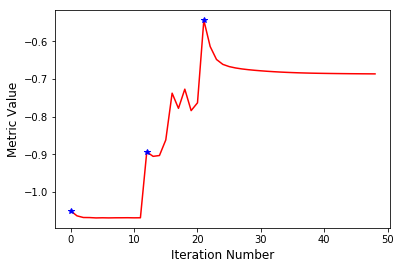

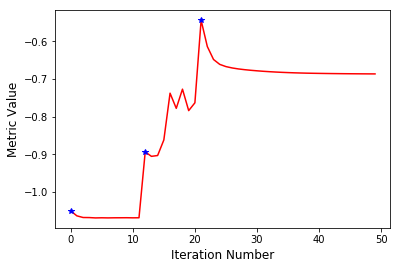

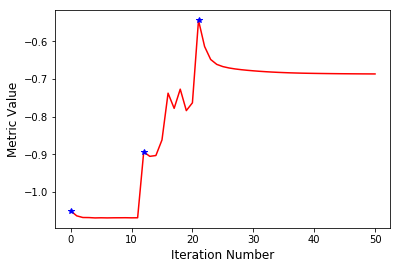

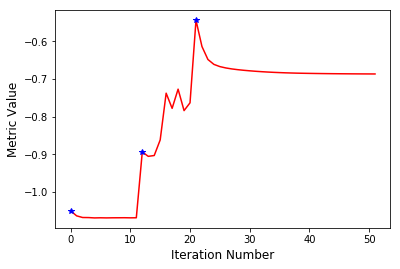

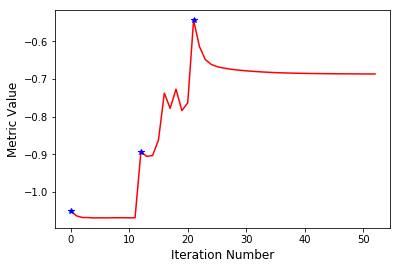

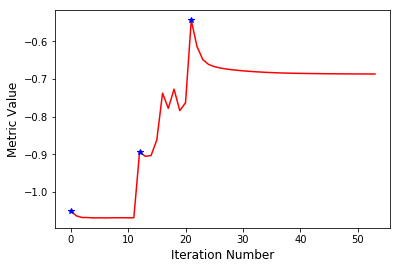

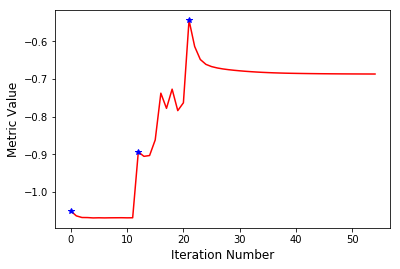

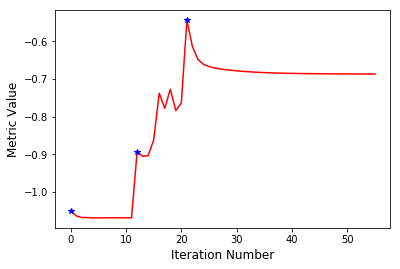

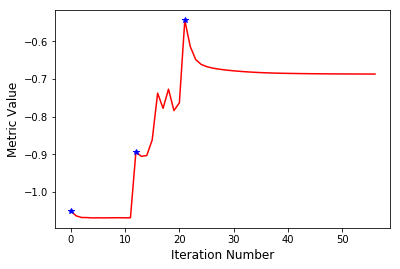

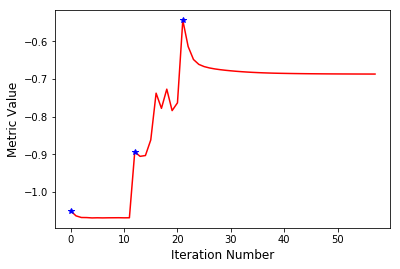

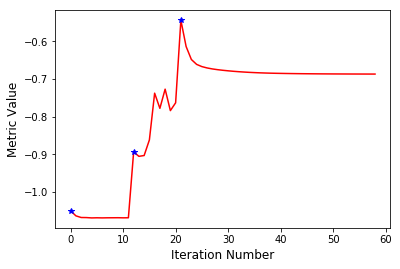

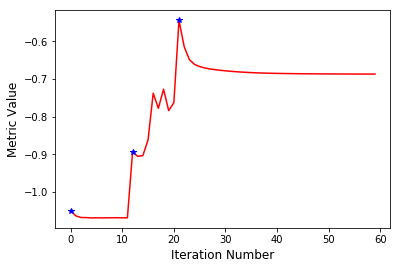

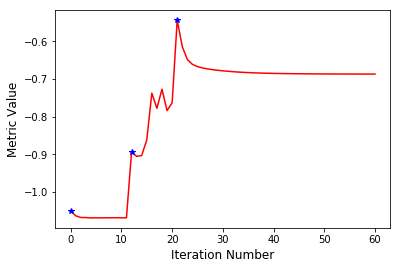

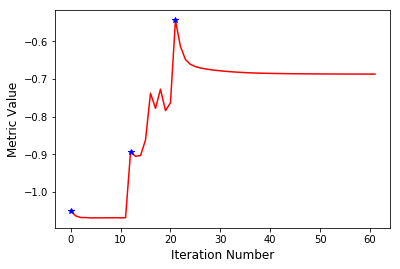

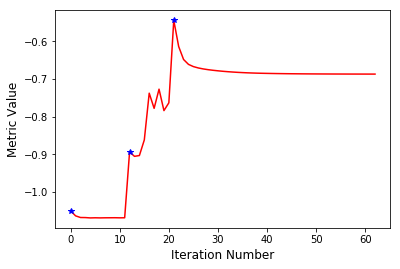

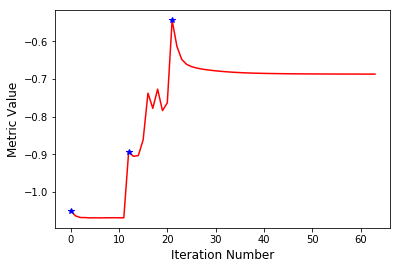

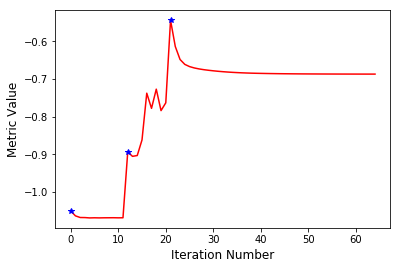

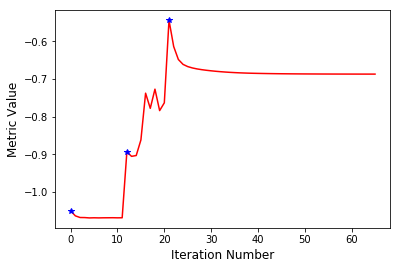

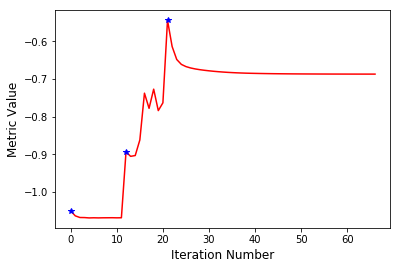

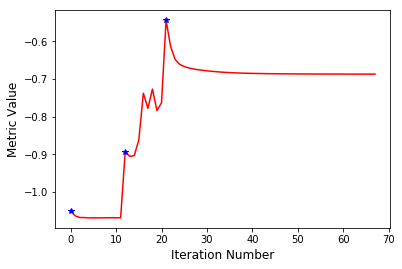

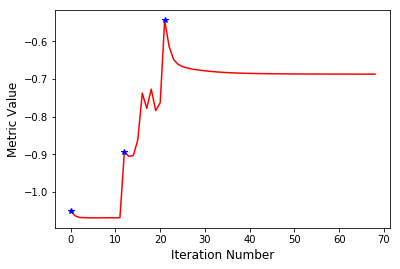

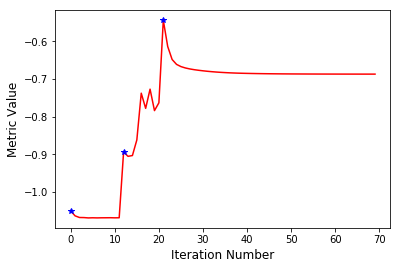

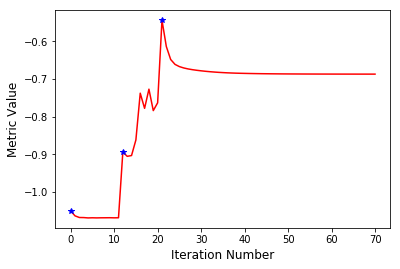

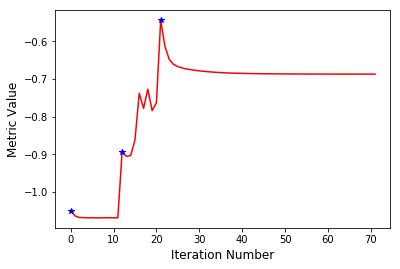

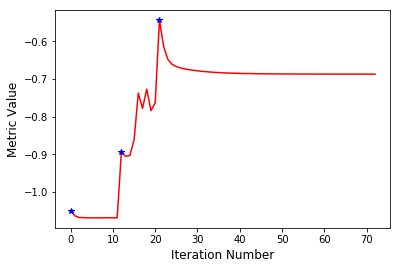

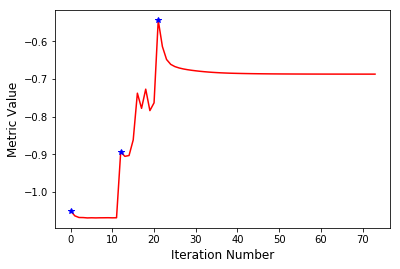

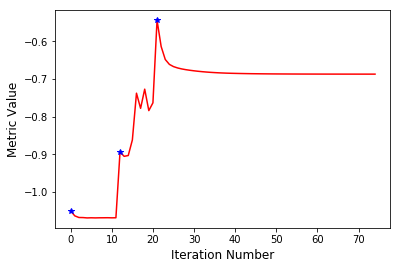

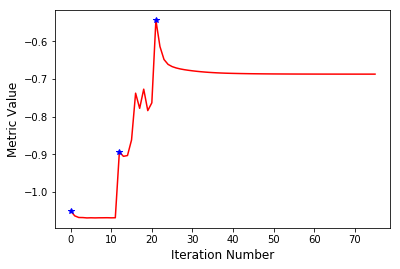

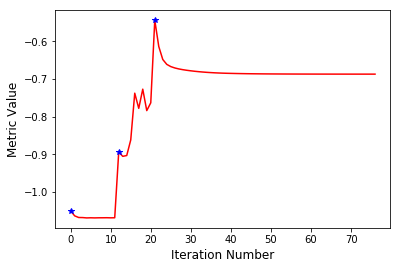

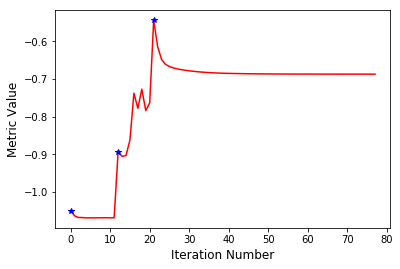

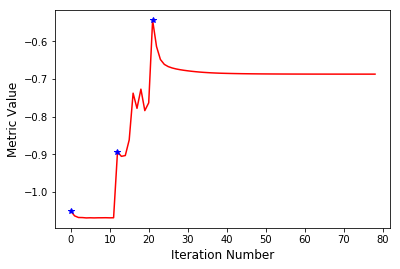

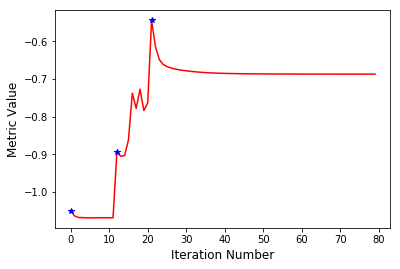

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 59.
Final metric value: -0.6873989041601255
KneeRep_output/9404954R//TP72/001.dcm
KneeRep_output/9404954R//TP72/002.dcm
KneeRep_output/9404954R//TP72/003.dcm
KneeRep_output/9404954R//TP72/004.dcm
KneeRep_output/9404954R//TP72/005.dcm
KneeRep_output/9404954R//TP72/006.dcm
KneeRep_output/9404954R//TP72/007.dcm
KneeRep_output/9404954R//TP72/008.dcm
KneeRep_output/9404954R//TP72/009.dcm
KneeRep_output/9404954R//TP72/010.dcm
KneeRep_output/9404954R//TP72/011.dcm
KneeRep_output/9404954R//TP72/012.dcm
KneeRep_output/9404954R//TP72/013.dcm
KneeRep_output/9404954R//TP72/014.dcm
KneeRep_output/9404954R//TP72/015.dcm
KneeRep_output/9404954R//TP72/016.dcm
KneeRep_output/9404954R//TP72/017.dcm
KneeRep_output/9404954R//TP72/018.dcm
KneeRep_output/9404954R//TP72/019.dcm
KneeRep_output/9404954R//TP72/020.dcm
KneeRep_output/9404954R//TP72/021.dcm
KneeRep_output/9404954R//TP72/022.dcm
KneeRep_outp

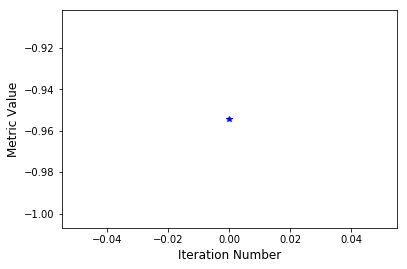

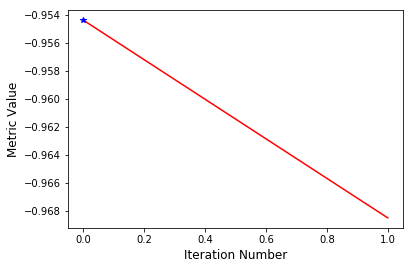

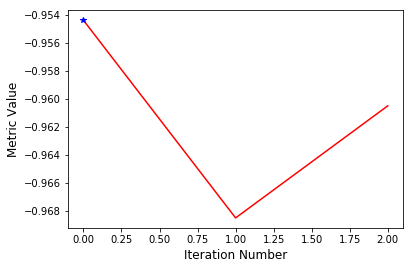

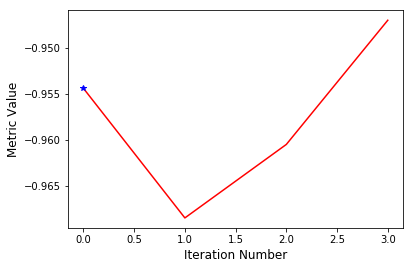

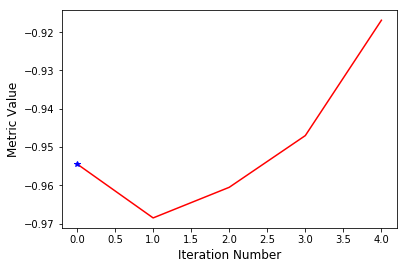

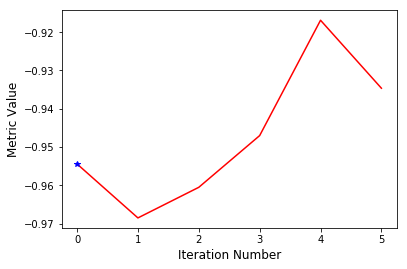

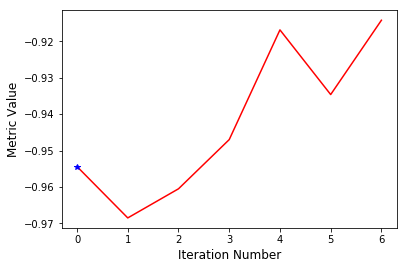

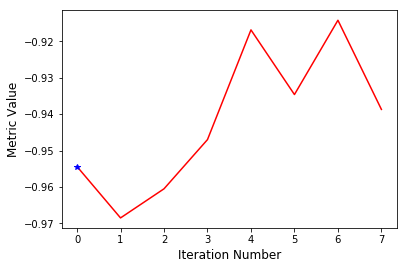

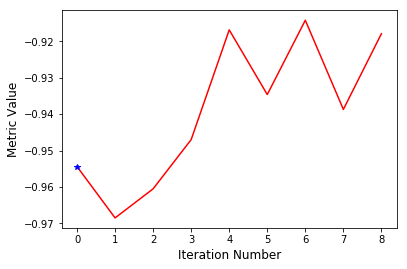

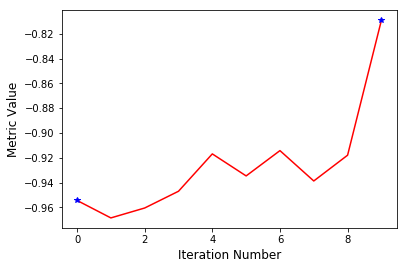

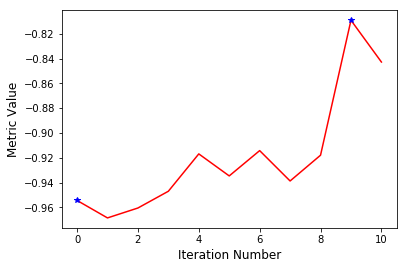

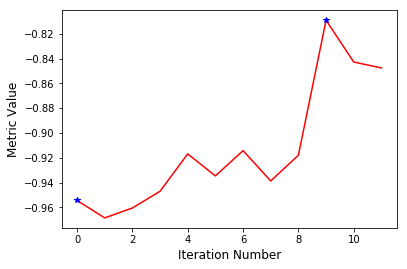

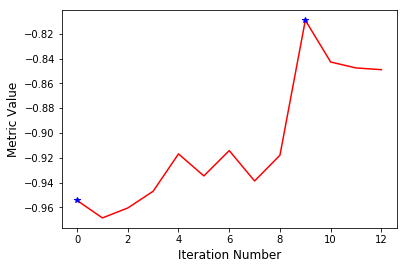

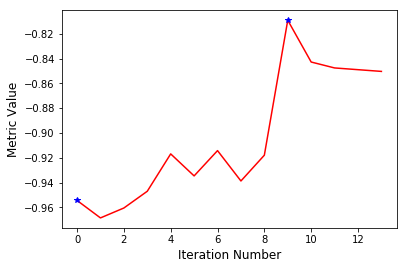

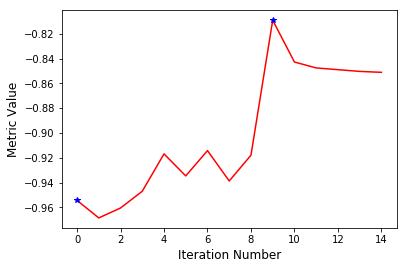

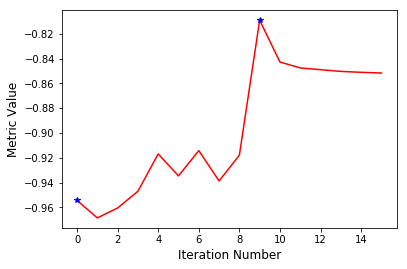

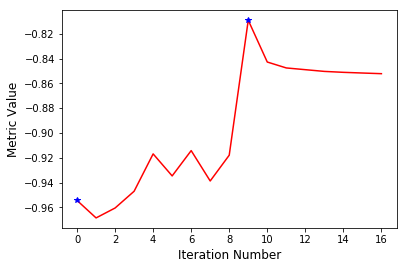

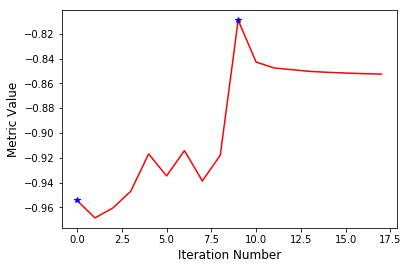

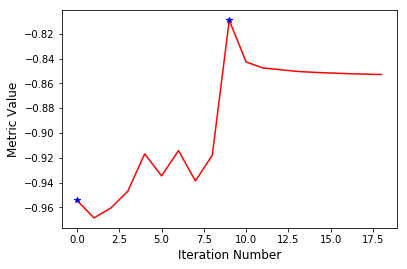

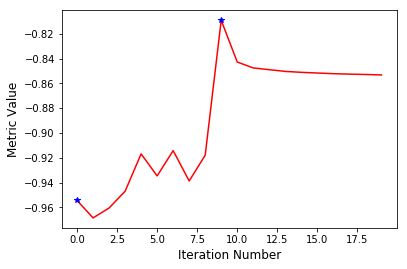

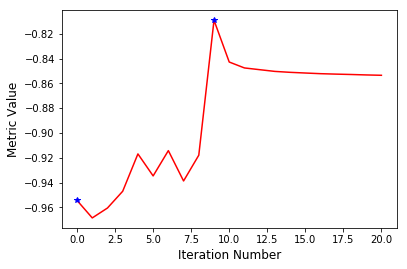

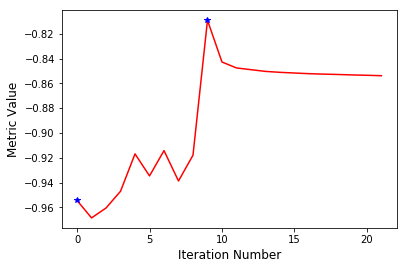

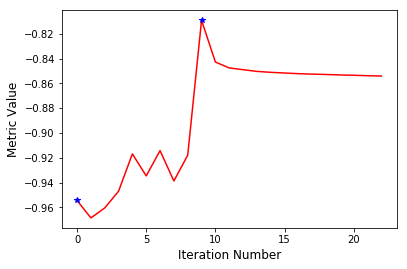

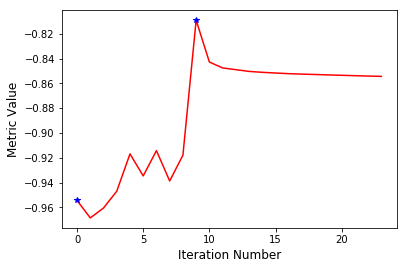

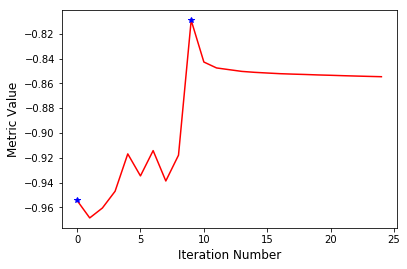

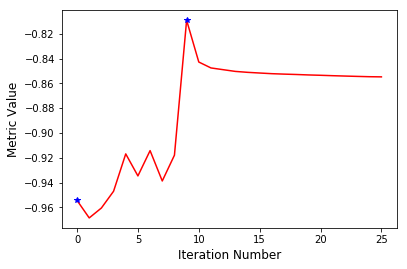

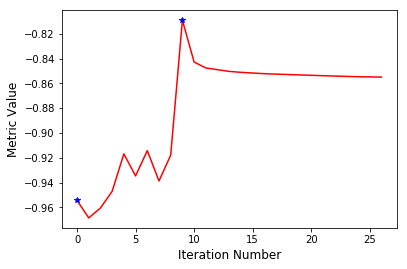

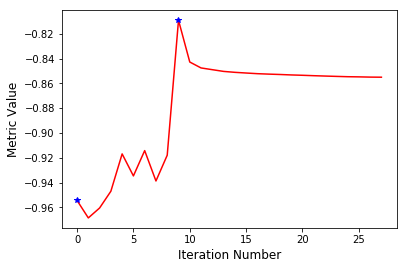

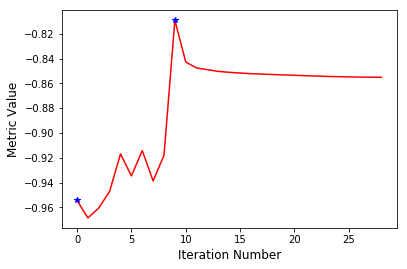

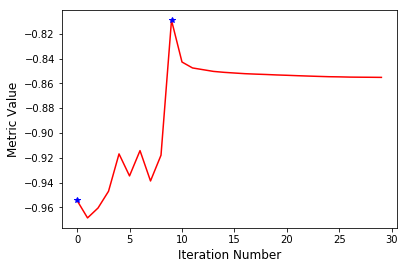

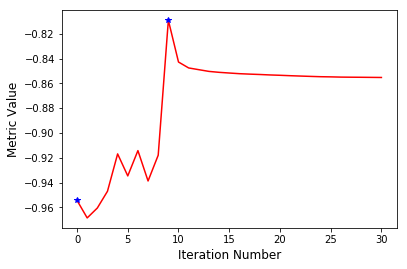

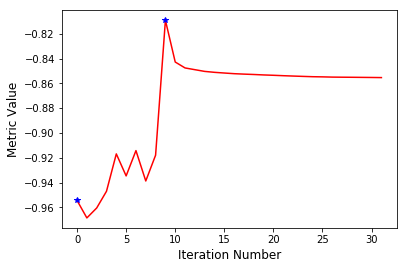

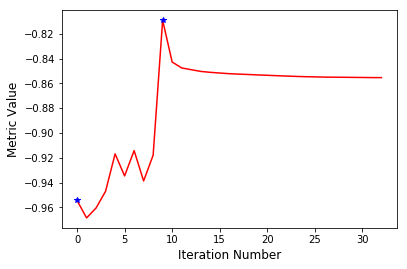

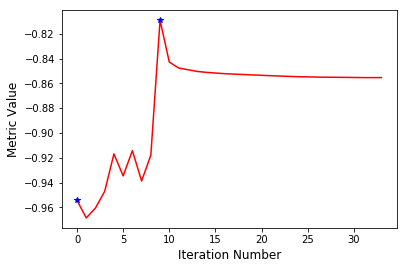

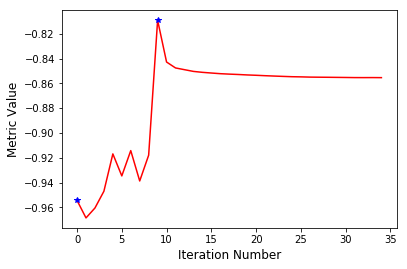

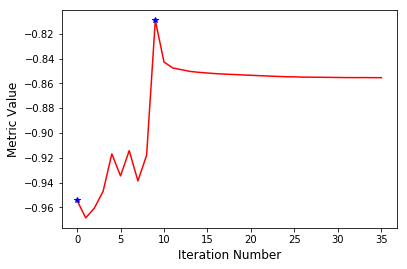

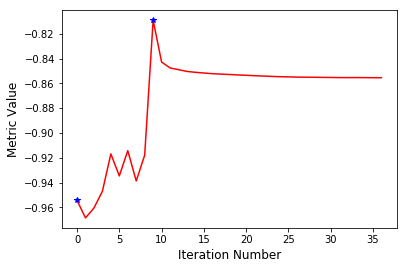

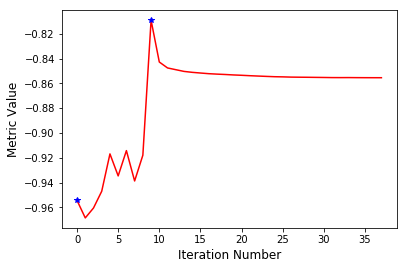

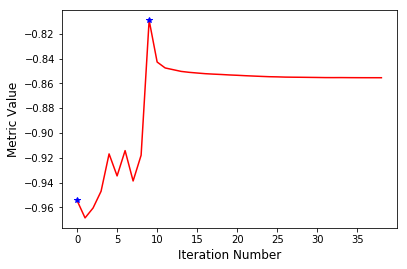

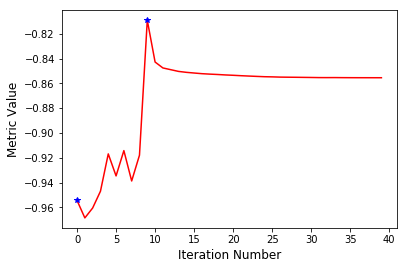

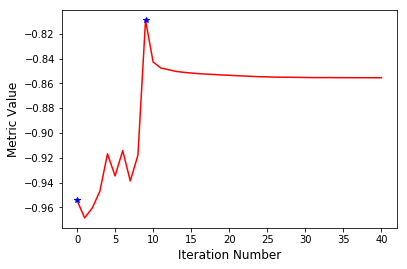

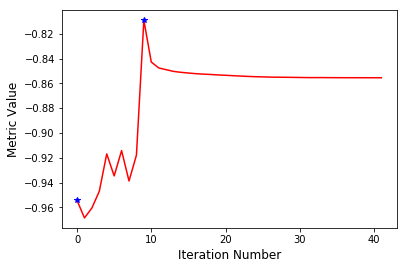

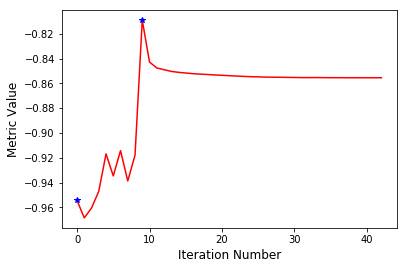

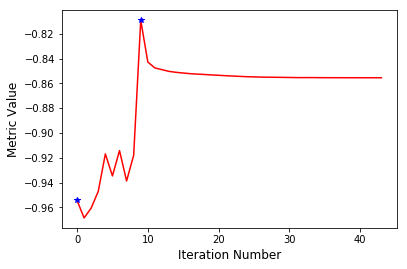

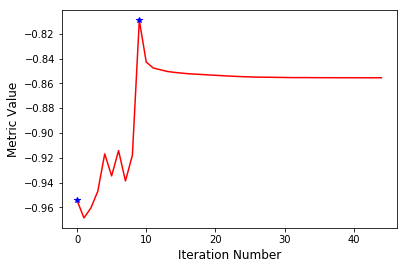

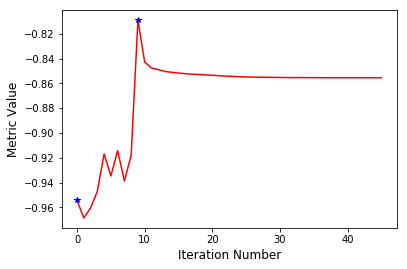

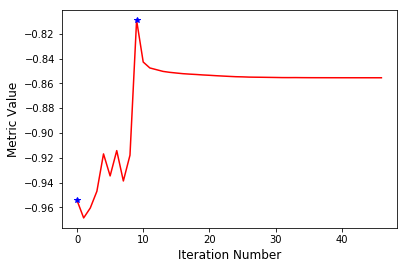

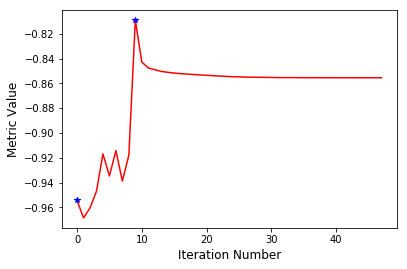

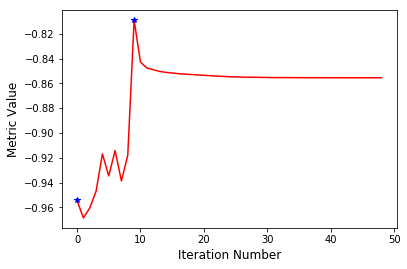

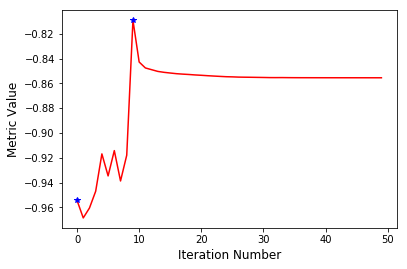

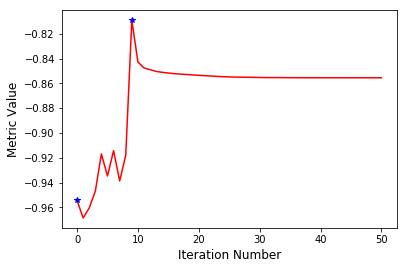

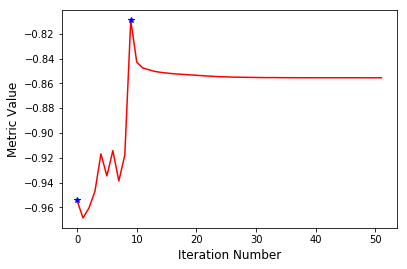

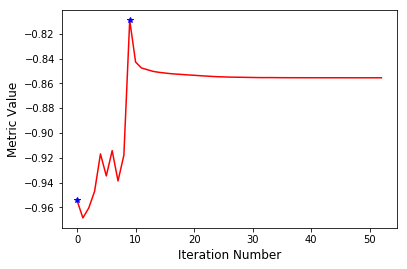

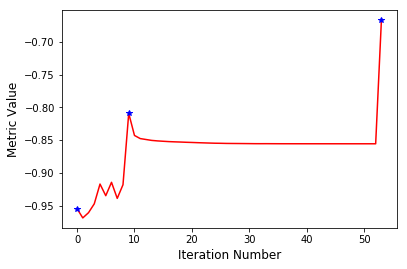

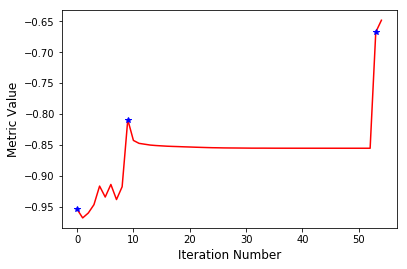

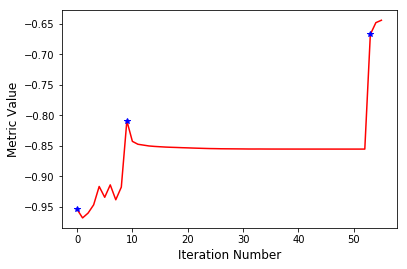

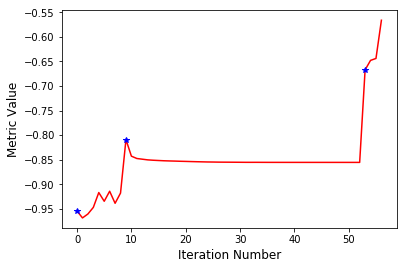

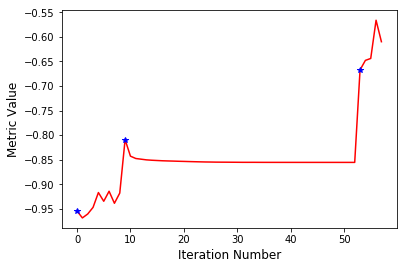

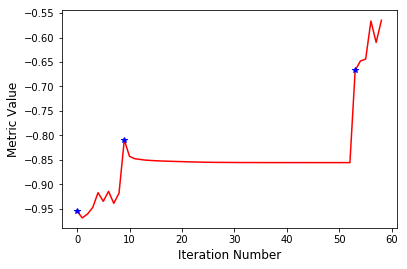

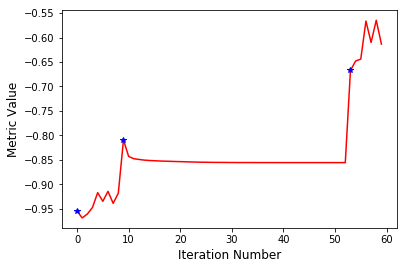

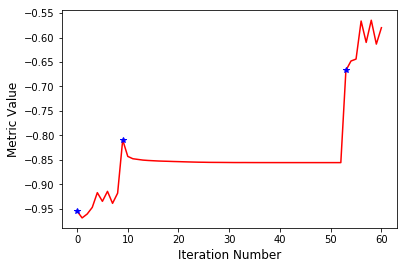

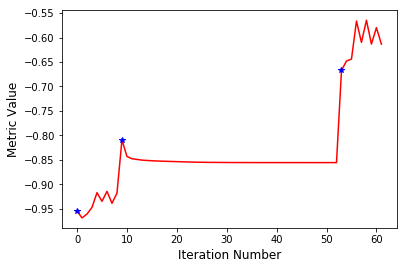

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
Final metric value: -0.590091580369662
KneeRep_output/9404954R//TP96/001.dcm
KneeRep_output/9404954R//TP96/002.dcm
KneeRep_output/9404954R//TP96/003.dcm
KneeRep_output/9404954R//TP96/004.dcm
KneeRep_output/9404954R//TP96/005.dcm
KneeRep_output/9404954R//TP96/006.dcm
KneeRep_output/9404954R//TP96/007.dcm
KneeRep_output/9404954R//TP96/008.dcm
KneeRep_output/9404954R//TP96/009.dcm
KneeRep_output/9404954R//TP96/010.dcm
KneeRep_output/9404954R//TP96/011.dcm
KneeRep_output/9404954R//TP96/012.dcm
KneeRep_output/9404954R//TP96/013.dcm
KneeRep_output/9404954R//TP96/014.dcm
KneeRep_output/9404954R//TP96/015.dcm
KneeRep_output/9404954R//TP96/016.dcm
KneeRep_output/9404954R//TP96/017.dcm
KneeRep_output/9404954R//TP96/018.dcm
KneeRep_output/9404954R//TP96/019.dcm
KneeRep_output/9404954R//TP96/020.dcm
KneeRep_output/9404954R//TP96/021.dcm
KneeRep_output/9404954R//TP96/022.dcm
KneeRep_output

In [25]:
#split seqs for a case
from subprocess import call

def cp_dir(source, target):
    if platform=='win32':
        shutil.copytree(source, target)
    else:
        call(['cp', '-a', source, target]) # Linux
    print('copying:',source)


for casei in caselist:
    pi = casei['pid']
    side = casei['side']
    case_outputpath = outputpath + pi+side +'/'
    if not os.path.exists(case_outputpath):
        os.mkdir(case_outputpath)
        print('Mkdir:',case_outputpath) 
        
        
    regtp = casei['TP']
    if len(regtp)<2:
        print(pi,'not enough TPs')
        continue
        
    tp1 = regtp[0]
    tp1_casepath = getdcmpath(pi,0,side)
    tp1_outputpath = case_outputpath + '/TP'+ TPS[tp1] + '/'
    
    if not os.path.exists(tp1_outputpath):
        cp_dir(tp1_casepath,tp1_outputpath)
    
    for tp2 in regtp[1:]:
        
        tp2_casepath = getdcmpath(pi,tp2,side)
        if tp2_casepath is None:
            print('cannot find dcm path for TPid',tp2)
            continue
        else:
            print('dcm path for TPid',tp2,tp2_casepath)
    
        
        tp2_outputpath = case_outputpath + '/TP'+ TPS[tp2] + '/'
        
        
        if not os.path.exists(tp2_outputpath):
            cp_dir(tp2_casepath,tp2_outputpath)

        TP1path = []
        TP2path = []
    
        flist = os.listdir(tp1_outputpath)    
        for file in flist:
            if ('.dcm') not in file:
                del flist[flist.index(file)]

        for j in range(0,len(flist)):
            for k in range(j+1,len(flist)):
                num=int(flist[j][:-4])
                num2=int(flist[k][:-4])
                if num>num2:
                    tmp=flist[j]
                    flist[j]=flist[k]
                    flist[k]=tmp

        for f in flist:
            dicomfilename = tp1_outputpath+f
            dcmimgcr = pydicom.read_file(dicomfilename)
            if abs(float(dcmimgcr.ImageOrientationPatient[0]))<abs(float(dcmimgcr.ImageOrientationPatient[1])):
                #coronal slice showing scan areas
                print('coronal',dicomfilename)
                os.remove(dicomfilename)
            else:
                TP1path.append(dicomfilename)


        flist = os.listdir(tp2_outputpath)    
        for file in flist:
            if ('.dcm') not in file:
                del flist[flist.index(file)]
        for j in range(0,len(flist)):
            for k in range(j+1,len(flist)):
                num=int(flist[j][:-4])
                num2=int(flist[k][:-4])

                if num>num2:
                    tmp=flist[j]
                    flist[j]=flist[k]
                    flist[k]=tmp

        for f in flist:
            dicomfilename = tp2_outputpath+f
            dcmimgcr = pydicom.read_file(dicomfilename)
            if abs(float(dcmimgcr.ImageOrientationPatient[0]))<abs(float(dcmimgcr.ImageOrientationPatient[1])):
                #coronal slice showing scan areas
                print('coronal',dicomfilename)
                os.remove(dicomfilename)
            else:
                TP2path.append(dicomfilename)
        

        reader = sitk.ImageSeriesReader()
        print("reading image......")
        fixed_image = sitk.ReadImage(TP1path)
        TP2_moving_image = sitk.ReadImage(TP2path)     
        print("TP2 initial alignment......")    
        ###  FOR TP2    
        initial_transform = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image,TP2_moving_image.GetPixelID()), 
                                                          TP2_moving_image, 
                                                          sitk.Similarity3DTransform(), 
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)
        final_dicom_path = tp2_outputpath


        registration_method = sitk.ImageRegistrationMethod()
        registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
        #registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=256)
        registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
        registration_method.SetMetricSamplingPercentage(0.1)

        registration_method.SetInterpolator(sitk.sitkLinear)
        #registration_method.SetInterpolator(sitk.sitkBSpline)
        

        registration_method.SetOptimizerAsGradientDescent(learningRate=0.5, numberOfIterations=200) #, estimateLearningRate=registration_method.EachIteration)
        registration_method.SetOptimizerScalesFromPhysicalShift() 

        final_transform = sitk.Similarity3DTransform(initial_transform)
        registration_method.SetInitialTransform(final_transform)
        registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
        registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
        registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

        registration_method.AddCommand(sitk.sitkStartEvent,metric_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent,metric_end_plot)
        registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
                                       metric_update_multires_iterations) 
        registration_method.AddCommand(sitk.sitkIterationEvent, 
                                       lambda: metric_plot_values(registration_method))

        registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                    sitk.Cast(TP2_moving_image, sitk.sitkFloat32))

        print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
        print('Final metric value: {0}'.format(registration_method.GetMetricValue()))

        # Save moving image after registration and view overlap using external viewer.
        save_transform_and_image(final_transform, fixed_image, TP2_moving_image,TP1path,TP2path,final_dicom_path,case_outputpath+ 'finalAlignment',False)
        
        if icafepath!='':
            icafesavepath = icafepath+'0_P'+pi+side+'_U'+'/'
            if not os.path.exists(icafesavepath):
                print('Init icafe dir')
                os.mkdir(icafesavepath)
            if tp2==10:
                SEQ = 'S109'
            else:
                SEQ = 'S10'+str(tp2)
                
            baselinetifname = icafesavepath + 'TH_0_P'+pi+side+'_U.tif'
            if tp2 == regtp[1]:
                resample = sitk.ResampleImageFilter()
                resample.SetInterpolator(sitk.sitkBSpline) 
                resample.SetOutputDirection(fixed_image.GetDirection())
                resample.SetOutputOrigin(fixed_image.GetOrigin())
                orig_spacing = TP2_moving_image.GetSpacing()
                new_spacing = (orig_spacing[0],orig_spacing[1],orig_spacing[0])
                resample.SetOutputSpacing(new_spacing)
                orig_size = np.array(TP2_moving_image.GetSize(), dtype=np.int)
                new_size = orig_size.copy()
                new_size[2] = int(orig_size[2]*(orig_spacing[2]/orig_spacing[0])+0.5)
                new_size = [int(s) for s in new_size]
                print(orig_size,new_size)
                resample.SetSize(new_size)
                exqimg = resample.Execute(fixed_image)
                sitk.WriteImage(sitk.Cast(exqimg,sitk.sitkInt16),baselinetifname)
                print('save to icafe path',baselinetifname)
                SEQT1 = 'S10'+str(tp1)
                sitk.WriteImage(sitk.Cast(exqimg,sitk.sitkInt16),icafesavepath + 'TH_0_P'+pi+side+'_U'+SEQT1 + '.tif')
                print('save to icafe path',icafesavepath + 'TH_0_P'+pi+side+'_U'+SEQT1 + '.tif')

            resample = sitk.ResampleImageFilter()
            resample.SetInterpolator(sitk.sitkBSpline) 
            resample.SetOutputDirection(TP2_moving_image.GetDirection())
            resample.SetOutputOrigin(TP2_moving_image.GetOrigin())
            orig_spacing = TP2_moving_image.GetSpacing()
            new_spacing = (orig_spacing[0],orig_spacing[1],orig_spacing[0])
            resample.SetOutputSpacing(new_spacing)
            orig_size = np.array(TP2_moving_image.GetSize(), dtype=np.int)
            new_size = orig_size.copy()
            new_size[2] = int(orig_size[2]*(orig_spacing[2]/orig_spacing[0])+0.5)
            new_size = [int(s) for s in new_size]
            print(orig_size,new_size)
            resample.SetSize(new_size)
            exqimg = resample.Execute(TP2_moving_image)
            sitk.WriteImage(sitk.Cast(exqimg,sitk.sitkInt16),icafesavepath + 'TH_0_P'+pi+side+'_U'+SEQ + '.tif')
            print('save to icafe path',icafesavepath + 'TH_0_P'+pi+side+'_U'+SEQ + '.tif')
        print(final_transform)
        print('\n')                
            
    

In [18]:
tp2,regtp[1]

(10, 1)

In [6]:
ei

NameError: name 'ei' is not defined

In [71]:
icafesavepath = icafepath+'0_P'+pi+'_U'+'/'
#SEQ = 'S100'
resample = sitk.ResampleImageFilter()
resample.SetInterpolator(sitk.sitkBSpline) 
resample.SetOutputOrigin(TP2_moving_image.GetOrigin())
orig_spacing = TP2_moving_image.GetSpacing()
new_spacing = (orig_spacing[0],orig_spacing[1],orig_spacing[0])
resample.SetOutputSpacing(new_spacing)
orig_size = np.array(TP2_moving_image.GetSize(), dtype=np.int)
new_size = orig_size.copy()
new_size[2] = int(orig_size[2]*(orig_spacing[2]/orig_spacing[0])+0.5)
new_size = [int(s) for s in new_size]
print(orig_size,new_size)
resample.SetSize(new_size)
exqimg = resample.Execute(sitk.Cast(TP2_moving_image,sitk.sitkInt16))
sitk.WriteImage(sitk.Cast(exqimg,sitk.sitkInt16),icafesavepath + 'TH_0_P'+pi+'_U'+SEQ + '.tif')


[384 384  75] [384, 384, 309]


In [70]:
exqimg.GetSpacing(),exqimg.GetSize()

((0.364583, 0.364583, 0.364583), (384, 384, 309))

In [73]:
icafesavepath + 'TH_0_P'+pi+'_U'+SEQ + '.tif'

'E:\\iCafe\\result\\OAIMTP/0_P9404954_U/TH_0_P9404954_US100.tif'

In [53]:
new_spacing

(0.36458333, 0.36458333, 1.5)